In [1]:

import numpy as np
import pandas as pd
import json
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


2024-12-19 17:28:34.504414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 17:28:34.520672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 17:28:34.536505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 17:28:34.541568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 17:28:34.554190: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

json file names and their threshold list:

results 1:[25, 50, 75, 90, 95, 99]

results 2: [10, 25, 40, 50, 60, 75, 90, 95]

results 3: [5, 15, 25, 35, 50, 70, 80, 90, 95]

cos = cosine simmilarity distance

l2 = L2/Euclidean distance

k_values: [5, 10, 15, 20, np.sqrt(N), (np.sqrt(N))/2, log2(N)]

In [3]:
SAVE = False
OUTPUT_FILE = "/home/users/orrbavly/GNN_project/percentiles/outputs/cos_3_all_results.csv"

In [4]:
# Load data
INPUT_JSON = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"
data_type = 'colon'

# Prepare Data

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.preprocessing

def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


In [6]:
def filter_samples(data, criteria):
    filtered_data = {key: value for key, value in data.items() if criteria not in key.lower()}
    return filtered_data


In [7]:
# Run this cell if you want to exclude sample groups from df.
# Case is case-sensitive
# all_results = filter_samples(all_results, criteria="nh")


In [8]:
def load_results(file_path, data_type='ovarian'):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict

In [9]:
all_results, labels_dict = load_results(INPUT_JSON, data_type=data_type)

# ML algorithms

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("KNN Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))


    return knn, {'model': 'KNN', 'accuracy': accuracy, 'classification_report': class_report}


## Logistic Regression:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    y_pred = logistic_regression.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Logistic Regression Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1]))


    return logistic_regression, {'model': 'Logistic Regression', 'accuracy': accuracy, 'classification_report': class_report}


## SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("SVM Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Use `predict_proba` if available, otherwise `decision_function`
    try:
        y_score = svm.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_score = svm.decision_function(X_test)  # Use decision function as a fallback
    print("ROC-AUC:", roc_auc_score(y_test, y_score))



    return svm, {'model': 'SVM', 'accuracy': accuracy, 'classification_report': class_report}


## Decition Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Decision Tree Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1]))

    return decision_tree, {'model': 'Decision Tree', 'accuracy': accuracy, 'classification_report': class_report}


## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test):
    random_forest = RandomForestClassifier(class_weight='balanced')
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Random Forest Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

    return random_forest, {'model': 'Random Forest', 'accuracy': accuracy, 'classification_report': class_report}


## MLP

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_mlp(X_train, X_test, y_train, y_test):
    neural_network = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    neural_network.fit(X_train, y_train)
    y_pred = neural_network.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("MLP Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, neural_network.predict_proba(X_test)[:, 1]))

    return neural_network, {'model': 'MLP', 'accuracy': accuracy, 'classification_report': class_report}


## XGBoost

In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("XGBoost Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return model, {'model': 'XGBoost', 'accuracy': accuracy, 'classification_report': class_report}


## Neural Network (Keras)

In [18]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Get probability predictions for ROC-AUC
    y_pred_proba = model.predict(X_test)  

    print("Neural Network Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

    return model, {'model': 'Neural Network', 'accuracy': accuracy, 'classification_report': class_report}


## Grid search

### SVM

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

def train_grid_svm(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and SVM
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('svm', SVC())  # SVM classifier
    ])

    # Define the parameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__gamma': [0.001, 0.01, 0.1, 1]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


### Random Forest

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score


def train_grid_rf(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and Random Forest
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
    ])

    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [20, 50, 100, 200, 300],
        'rf__max_depth': [5, 10, 15, 20, 30],
        'rf__min_samples_split': [2, 5, 10, 15],
        'rf__min_samples_leaf': [1, 2, 4, 8],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best ROC-AUC Score from Grid Search:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")


### MLP

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

def train_grid_mlp(X_train, X_test, y_train, y_test):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    # Create a pipeline with scaling and MLP
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('mlp', MLPClassifier(max_iter=2500))  # MLP classifier
    ])

    # Define the parameter grid
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'mlp__activation': ['tanh', 'relu'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__learning_rate': ['constant', 'adaptive']
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

### Neural Network (keras)

In [22]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow import keras
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Function to build a neural network model with specified parameters
# def build_model(num_layers=2, units=32, optimizer='adam'):
#     model = keras.Sequential()
#     model.add(keras.layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    
#     # Add additional hidden layers based on num_layers
#     for _ in range(num_layers - 1):
#         model.add(keras.layers.Dense(units, activation='relu'))
    
#     # Output layer
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile model
#     model.compile(optimizer=optimizer,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Wrapper for the model
# model = KerasClassifier(build_fn=build_model, verbose=0)

# # Define the parameter grid
# param_grid = {
#     'num_layers': [1, 2, 3],  # Number of hidden layers
#     'units': [16, 32, 64],    # Number of units in each layer
#     'batch_size': [16, 32],   # Batch size
#     'epochs': [20, 50],       # Number of epochs
#     'optimizer': ['adam', 'rmsprop']  # Optimizer type
# }

# # Initialize GridSearchCV with the Keras model and parameter grid
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# # Print the evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print("Neural Network Results on Test Set:")
# print(f"Accuracy: {accuracy}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

### XGBoost

In [23]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

def train_grid_xgboost(X_train, X_test, y_train, y_test):
    # Define the parameter grid, including scale_pos_weight
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1.5, 1.7, 1.8, 2.0]  # Adjusted based on class imbalance for colon (90/49)
    }

    # Initialize the XGBClassifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize GridSearchCV, focusing on recall for label 1
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=0)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Recall Score from Grid Search:", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nXGBoost Results with Best Parameters for Label 1 Recall:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")

# Various K values

In [24]:
results = []  # Holds all the different k values (and their models) results.
models = []


In [25]:
def run_evaluation(X_train, X_test, y_train, y_test, k_value, results, models, save_results=True):
    model_functions = [
        ('KNN', train_and_evaluate_knn),
        ('Logistic Regression', train_and_evaluate_logistic_regression),
        ('SVM', train_and_evaluate_svm),
        ('Decision Tree', train_and_evaluate_decision_tree),
        ('Random Forest', train_and_evaluate_random_forest),
        ('MLP', train_and_evaluate_mlp),
        ('XGBoost', train_and_evaluate_xgboost), 
        ('Neural Network', train_and_evaluate_nn)
    ]

    for model_name, train_func in model_functions:
        model, result = train_func(X_train, X_test, y_train, y_test)
        if save_results:
            results.append({'k_value': k_value, **result})
            models.append({'k_value': k_value, 'model_name': model_name, 'model': model})


## all k

In [47]:
X_train, X_test, y_train, y_test = prepare_data(all_results, labels_dict)

In [34]:
print(y_train, len(y_train))
print(y_test, len(y_test))

[1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0
 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0] 111
[0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0] 28


In [35]:
from collections import Counter

# Count occurrences of 0 and 1
value_counts = Counter(labels_dict.values())

# Print the number of 0s and 1s
print(f"Number of 0s: {value_counts[0]}")
print(f"Number of 1s: {value_counts[1]}")

Number of 0s: 90
Number of 1s: 49


In [36]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=results, models=models)

KNN Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[18  2]
 [ 7  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        20
           1       0.33      0.12      0.18         8

    accuracy                           0.68        28
   macro avg       0.53      0.51      0.49        28
weighted avg       0.61      0.68      0.62        28

ROC-AUC: 0.421875
Logistic Regression Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[19  1]
 [ 8  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        20
           1       0.00      0.00      0.00         8

    accuracy                           0.68        28
   macro avg       0.35      0.47      0.40        28
weighted avg       0.50      0.68      0.58        28

ROC-AUC: 0.1375
SVM Results
Accuracy: 0.7142857142857143
Confusion Matrix:
[[20  0]
 [ 8  0]]
Classification R

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Random Forest Results
Accuracy: 0.5357142857142857
Confusion Matrix:
[[15  5]
 [ 8  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       0.00      0.00      0.00         8

    accuracy                           0.54        28
   macro avg       0.33      0.38      0.35        28
weighted avg       0.47      0.54      0.50        28

ROC-AUC: 0.30625
MLP Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[19  1]
 [ 8  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        20
           1       0.00      0.00      0.00         8

    accuracy                           0.68        28
   macro avg       0.35      0.47      0.40        28
weighted avg       0.50      0.68      0.58        28

ROC-AUC: 0.36250000000000004


XGBoost Results:
Accuracy: 0.5714285714285714
Confusion Matrix:
[[14  6]
 [ 6  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.25      0.25      0.25         8

    accuracy                           0.57        28
   macro avg       0.47      0.47      0.47        28
weighted avg       0.57      0.57      0.57        28

ROC-AUC: 0.32499999999999996


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-10 12:48:22.614164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-12-10 12:48:22.627061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
I0000 00:00:1733827712.082004 3778617 service.cc:146] XLA service 0x7f04500182f0 initialized for platform CUDA (this does

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Neural Network Results:
Accuracy: 0.6428571428571429
Confusion Matrix:
[[18  2]
 [ 8  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        20
           1       0.00      0.00      0.00         8

    accuracy                           0.64        28
   macro avg       0.35      0.45      0.39        28
weighted avg       0.49      0.64      0.56        28

ROC-AUC: 0.21875


In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a pipeline with scaling and SVM
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC())  # SVM classifier
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best Score: 0.6486166007905138
Test Accuracy: 0.6428571428571429
[[18  2]
 [ 8  0]]


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a pipeline with scaling and Random Forest
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('rf', RandomForestClassifier())  # Random Forest classifier
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best Score: 0.684189723320158
Test Accuracy: 0.5357142857142857
[[15  5]
 [ 8  0]]


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Create a pipeline with scaling and MLP
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPClassifier(max_iter=1000))  # MLP classifier
])

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}
Best Score: 0.6490118577075099
Test Accuracy: 0.7142857142857143
[[20  0]
 [ 8  0]]


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Average K

In [34]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = prepare_data(all_results, labels_dict, average_vectors=True)

In [35]:
run_evaluation(X_train_avg, X_test_avg, y_train_avg, y_test_avg, k_value="avg_k", results=results, models=models)


KNN Results
Accuracy: 0.625
Confusion Matrix:
[[12  4]
 [ 5  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.43      0.38      0.40         8

    accuracy                           0.62        24
   macro avg       0.57      0.56      0.56        24
weighted avg       0.61      0.62      0.62        24

ROC-AUC: 0.66796875
Logistic Regression Results
Accuracy: 0.6666666666666666
Confusion Matrix:
[[16  0]
 [ 8  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        16
           1       0.00      0.00      0.00         8

    accuracy                           0.67        24
   macro avg       0.33      0.50      0.40        24
weighted avg       0.44      0.67      0.53        24

ROC-AUC: 0.4765625
SVM Results
Accuracy: 0.6666666666666666
Confusion Matrix:
[[16  0]
 [ 8  0]]
Classification Report:
 

# Centrality 

## pagerank

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [37]:
feature_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality/pagerank_top10.csv")

In [38]:
def run_feature_selection(feature_df):
    # Step 1: Create Labels (1 for 'H', 0 for 'OC')
    feature_df['label'] = feature_df['graph_name'].apply(lambda x: 1 if 'OC' in x else 0)

    # Step 2: Split data into features (X) and labels (y)
    X = feature_df.drop(columns=['graph_name', 'label'])  # Features are all columns except 'graph_name' and 'label'
    y = feature_df['label']  # Labels are 1 (H) or 0 (OC)

    # Step 3: Split the dataset into training and testing sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    run_evaluation(X_train, X_test, y_train, y_test, k_value="page_rank", results=[], models=[], save_results=False)


In [39]:
run_feature_selection(feature_df)

KNN Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[14  3]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.50      0.27      0.35        11

    accuracy                           0.61        28
   macro avg       0.57      0.55      0.54        28
weighted avg       0.58      0.61      0.57        28

ROC-AUC: 0.5935828877005347
Logistic Regression Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[15  2]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        17
           1       0.67      0.36      0.47        11

    accuracy                           0.68        28
   macro avg       0.67      0.62      0.62        28
weighted avg       0.68      0.68      0.65        28

ROC-AUC: 0.7165775401069518
SVM Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[17  0]
 [11

# General EDA

## Analyzing Json files

In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
# Load the JSON files
ovarian_path = "/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json"
colon_path = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"

# Load and extract features for each group
ovarian_path_outlines = '/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json'
colon_path_outlines = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"


In [29]:
def load_percentiles(json_path):
    """Load JSON and structure each sample as a list of lists for plotting."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    samples = []
    for sample_name, percentiles_dict in data.items():
        # Convert each dictionary to a sorted list of lists
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
        samples.append(sample_data)
    
    return samples

def plot_percentiles(samples, dataset_name, k_labels):
    """Plot the mean and standard deviation of percentiles for each k value."""
    plt.figure(figsize=(10, 6))
    
    # Assign a unique color for each k value
    colors = plt.cm.viridis(np.linspace(0, 1, len(k_labels)))
    
    for k_index, k_label in enumerate(k_labels):
        k_percentiles = []
        
        # Collect the k-th percentile data across all samples
        for sample in samples:
            if k_index < len(sample):  # Ensure we don't index out of bounds
                percentiles = sample[k_index][1:]  # Skip the first element (k value)
                k_percentiles.append(percentiles)
        
        k_percentiles = np.array(k_percentiles)
        
        # Calculate mean and standard deviation
        mean_percentiles = np.mean(k_percentiles, axis=0)
        std_percentiles = np.std(k_percentiles, axis=0)
        
        # Plot with error bars
        plt.plot(mean_percentiles, color=colors[k_index], label=f'k={k_label}')
        plt.fill_between(range(len(mean_percentiles)), 
                         mean_percentiles - std_percentiles, 
                         mean_percentiles + std_percentiles, 
                         color=colors[k_index], alpha=0.2)
    
    plt.title(f"Percentile Values for {dataset_name} Dataset")
    plt.xlabel("Percentile Index")
    plt.ylabel("Percentile Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [30]:
import seaborn as sns

def plot_grouped_histograms(samples_group_0, samples_group_1, k_labels):
    """Plot grouped histograms for each k value with normalized frequency and arranged in a grid."""
    n_k = len(k_labels)
    n_cols = 3  # Number of plots per row
    n_rows = (n_k + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
    axs = axs.flatten()  # Flatten to easily iterate over each axis
    
    for k_index, k_label in enumerate(k_labels):
        # Collect percentiles for the current k value from each group
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group for the current k value
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Calculate x-axis limits dynamically based on the data range
        min_val = min(group_0_data.min(), group_1_data.min())
        max_val = max(group_0_data.max(), group_1_data.max())
        x_margin = 0.05 * (max_val - min_val)  # Add a margin to the limits
        
        # Plot histogram for each group with normalization
        axs[k_index].hist(group_0_data, bins=30, alpha=0.5, label='Group 0', color='blue', density=True)
        axs[k_index].hist(group_1_data, bins=30, alpha=0.5, label='Group 1', color='orange', density=True)
        axs[k_index].set_title(f'k={k_label}')
        axs[k_index].set_ylabel("Density")
        axs[k_index].set_yscale('log')
        axs[k_index].set_xlim(min_val - x_margin, max_val + x_margin)  # Set dynamic x-axis limits
        axs[k_index].legend()
    
    # Hide any unused subplots
    for i in range(k_index + 1, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_box_plots(samples_group_0, samples_group_1, k_labels):
    """Plot box plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the box plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
       # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.boxplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'], legend=False)
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def plot_violin_plots(samples_group_0, samples_group_1, k_labels):
    """Plot violin plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the violin plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.violinplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'])
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def run_plots(samples_group_0, samples_group_1, k_labels):
    plot_grouped_histograms(samples_group_0, samples_group_1, k_labels)
    plot_box_plots(samples_group_0, samples_group_1, k_labels)
    plot_violin_plots(samples_group_0, samples_group_1, k_labels)


def load_json_groups(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    for sample_name, percentiles_dict in data.items():
        if 'H' in sample_name or 'low' in sample_name:
            # Convert each dictionary to a sorted list of lists
            sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
            group_0.append(sample_data)
        elif 'OC' in sample_name or 'high' in sample_name:
            # Convert each dictionary to a sorted list of lists
            sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
            group_1.append(sample_data)
    
    return group_0, group_1

In [31]:
ovarian_data = load_percentiles(ovarian_path)
colon_data = load_percentiles(colon_path)

# Define k values (assuming they are the same for both datasets)
k_values = [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']  # Custom labels as specified


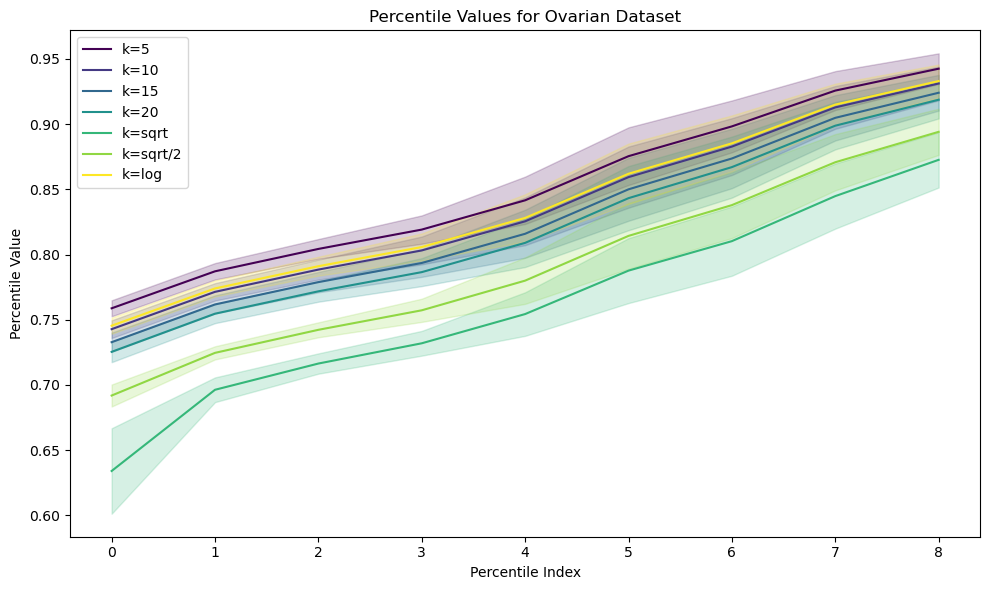

In [31]:
# Plot percentiles for ovarian dataset
plot_percentiles(ovarian_data, "Ovarian", k_values)

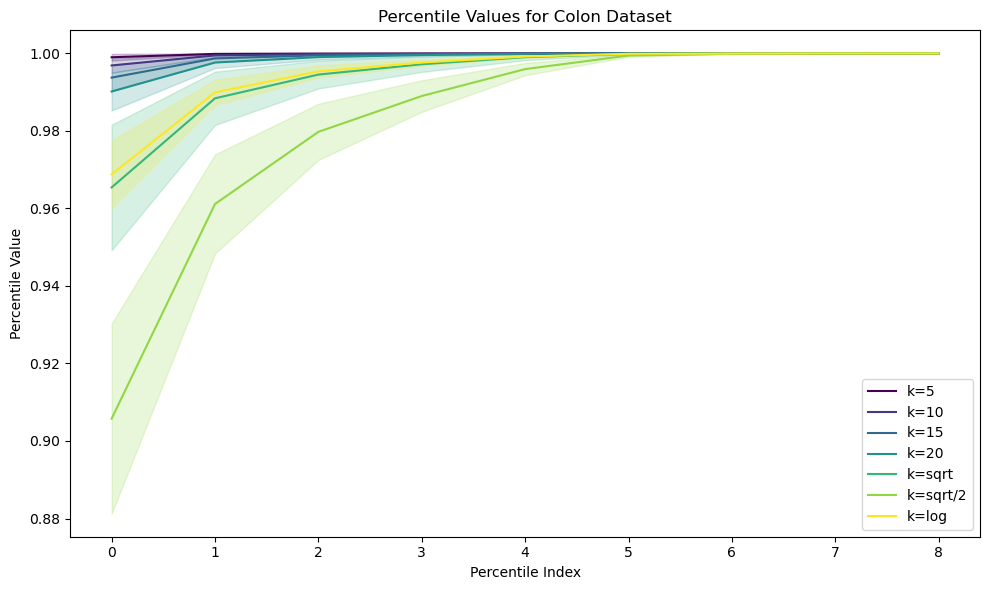

In [32]:
# Plot percentiles for colon dataset
plot_percentiles(colon_data, "Colon", k_values)

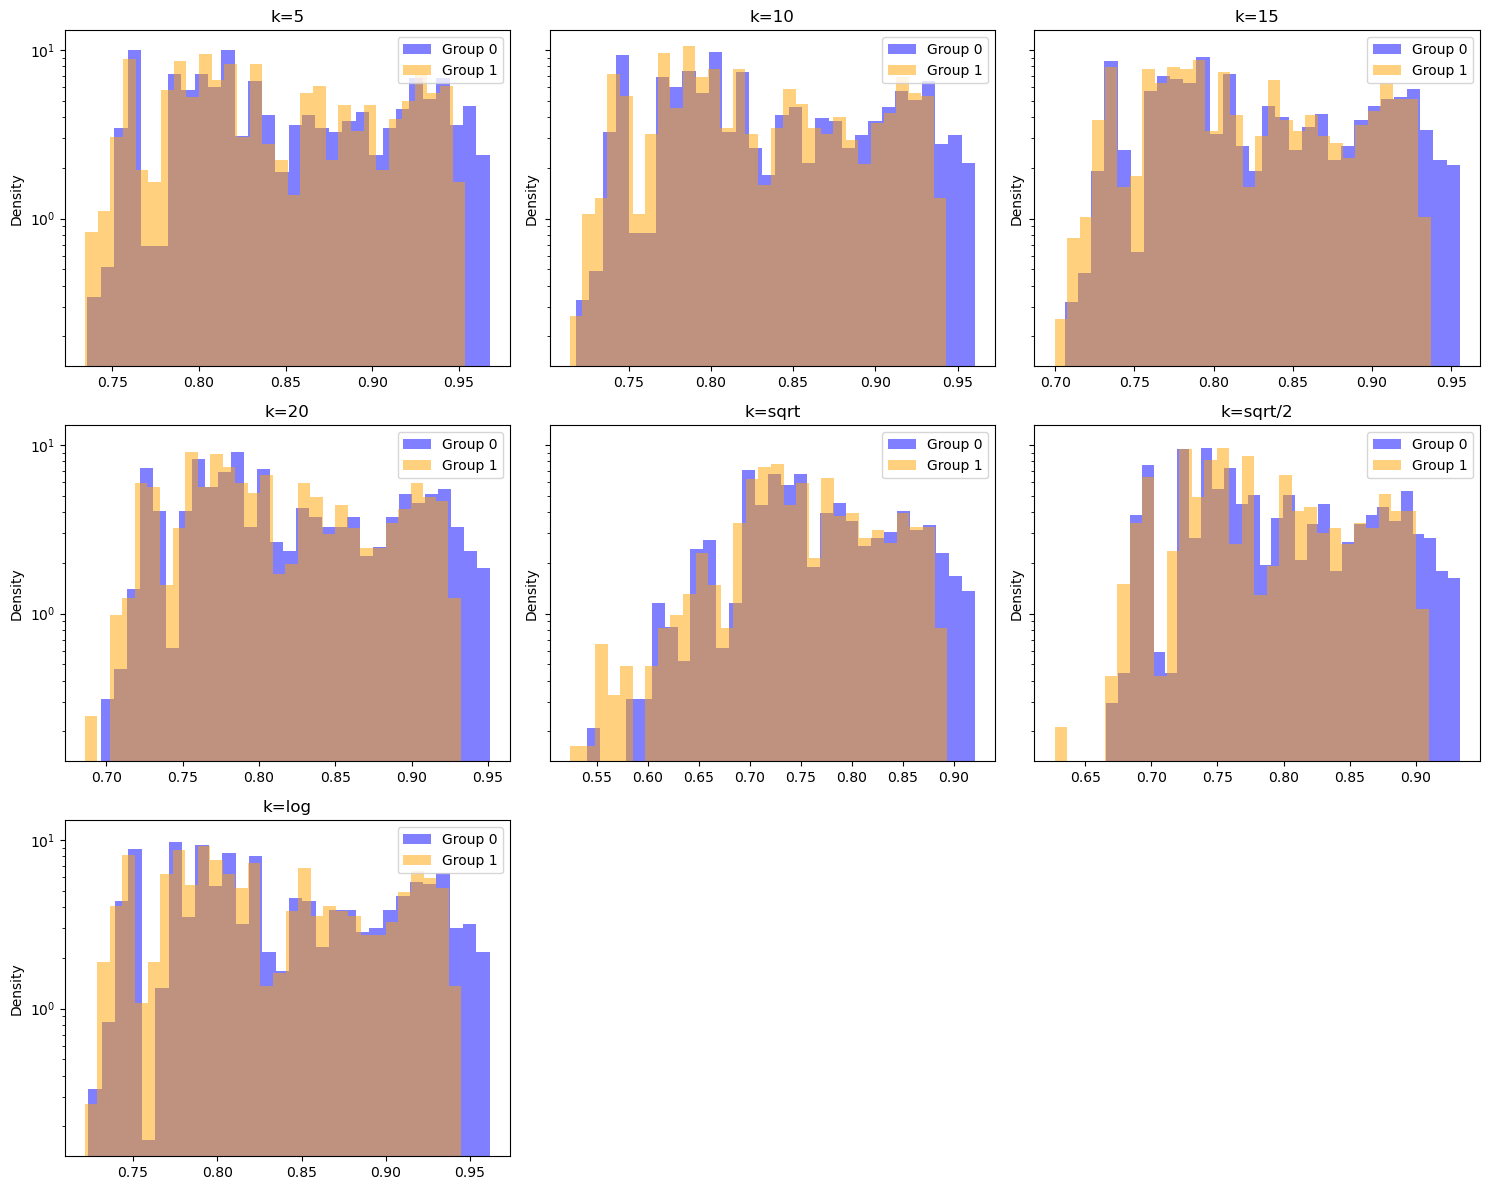

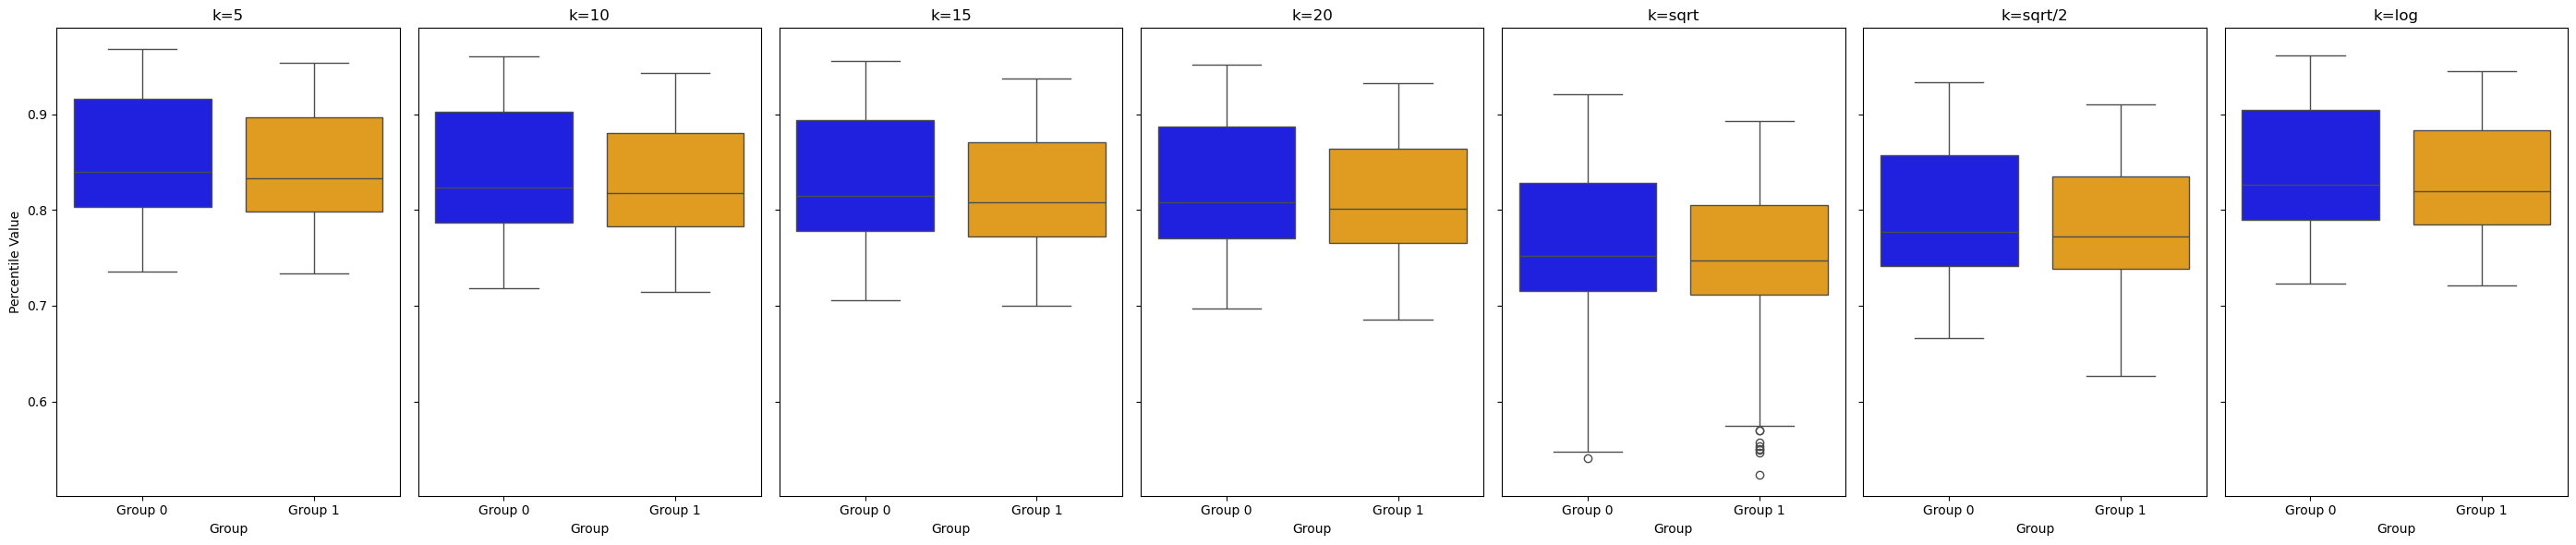

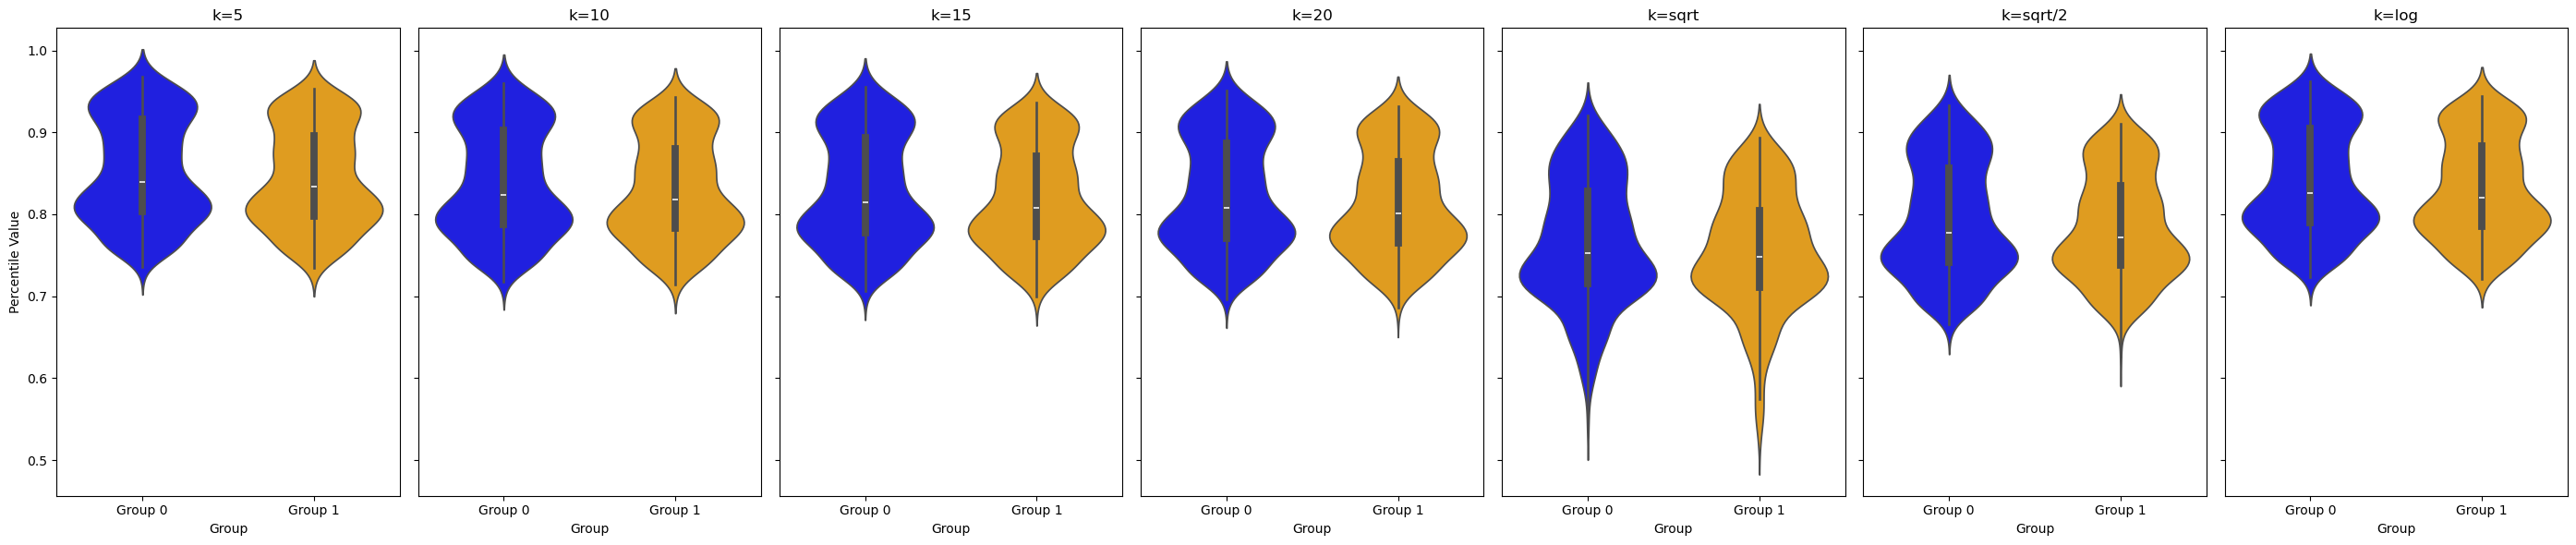

In [45]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
run_plots(group0, group1, k_values)

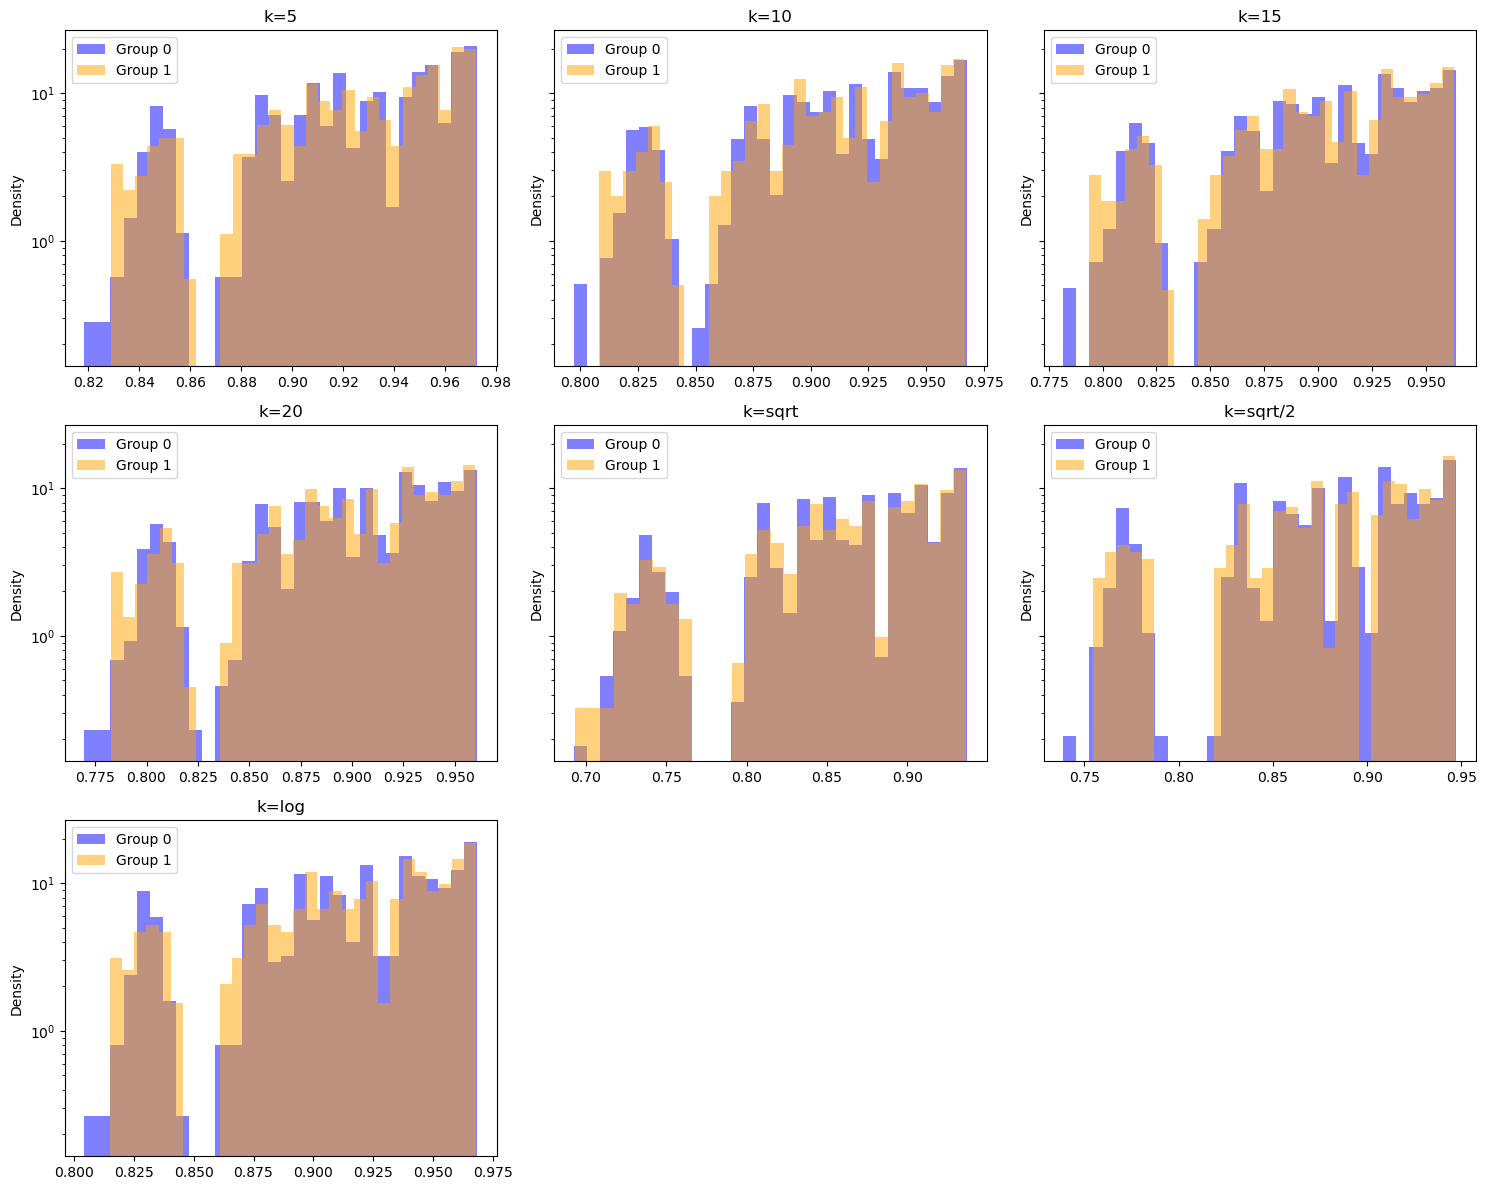

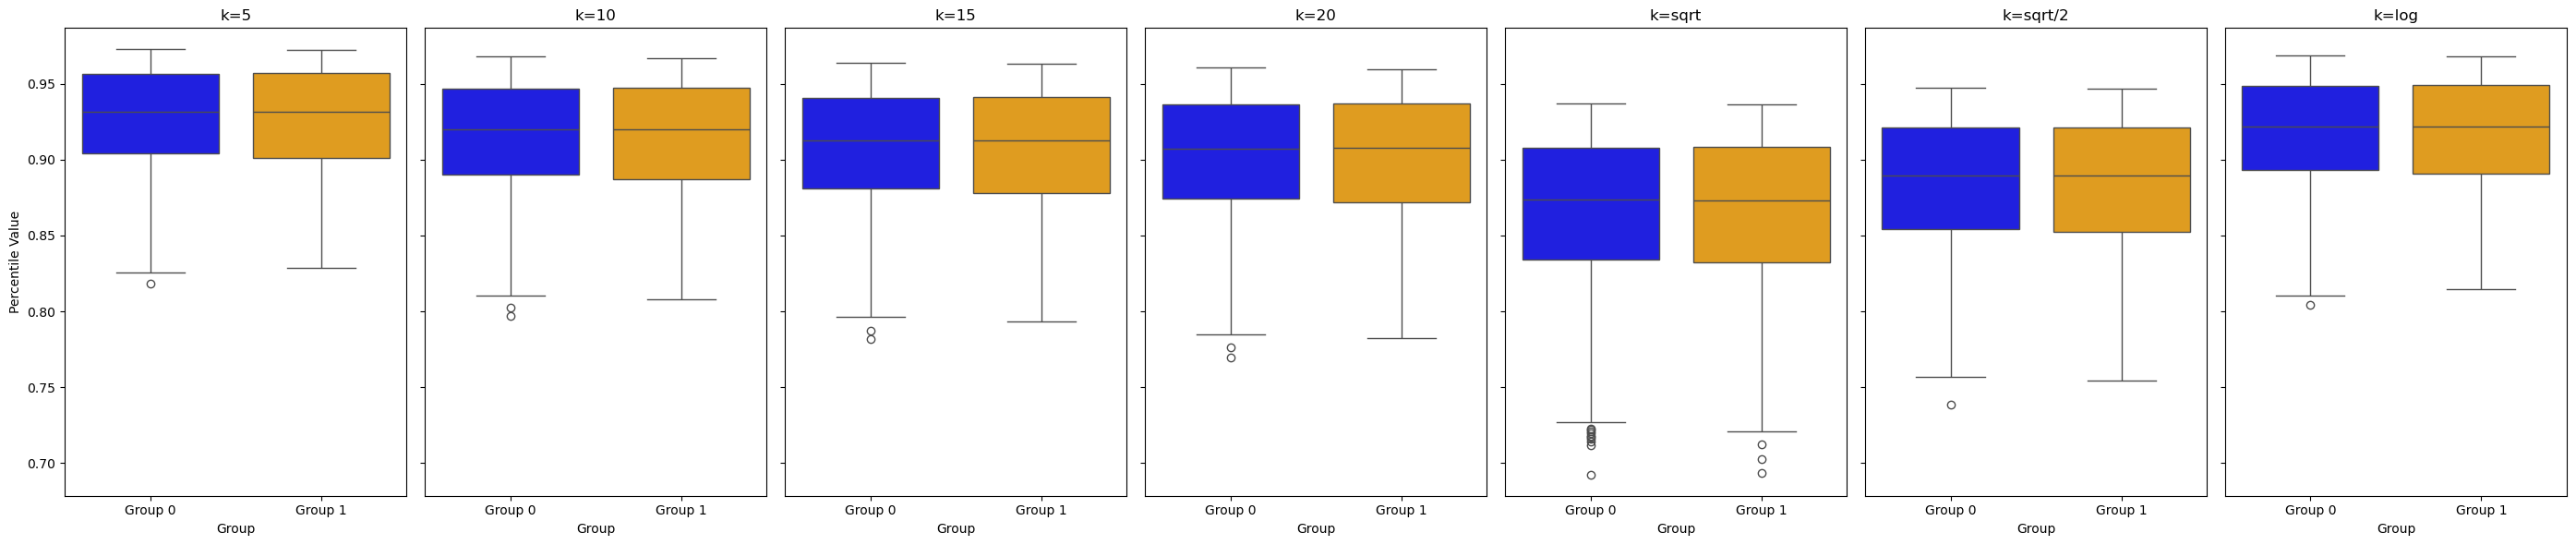

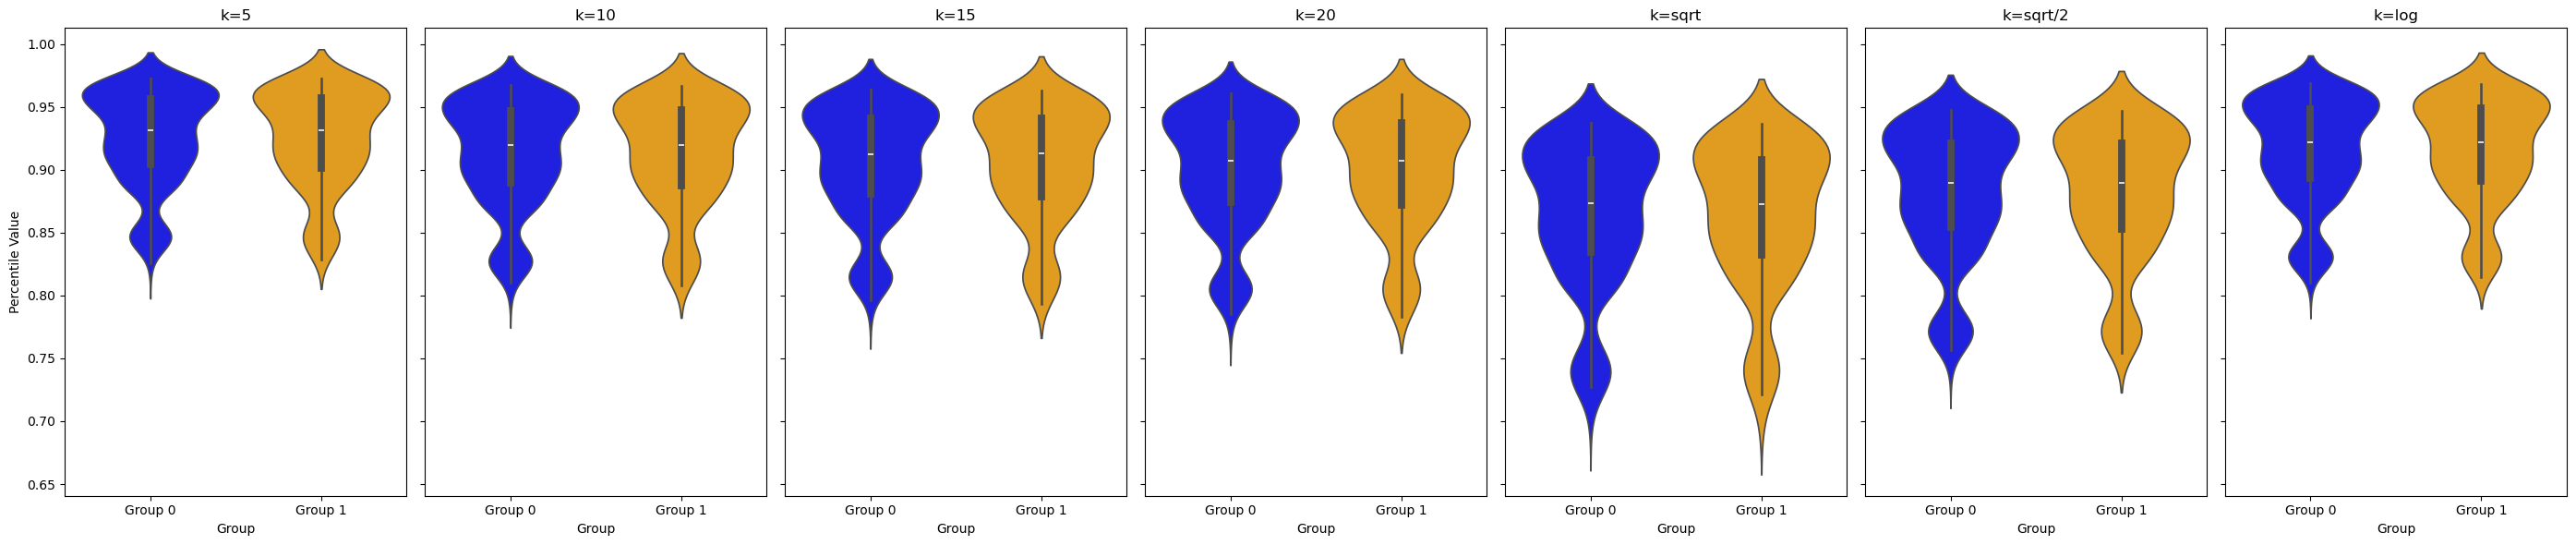

In [34]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_cos_3_all_TRA.json")
run_plots(group0, group1, k_values)

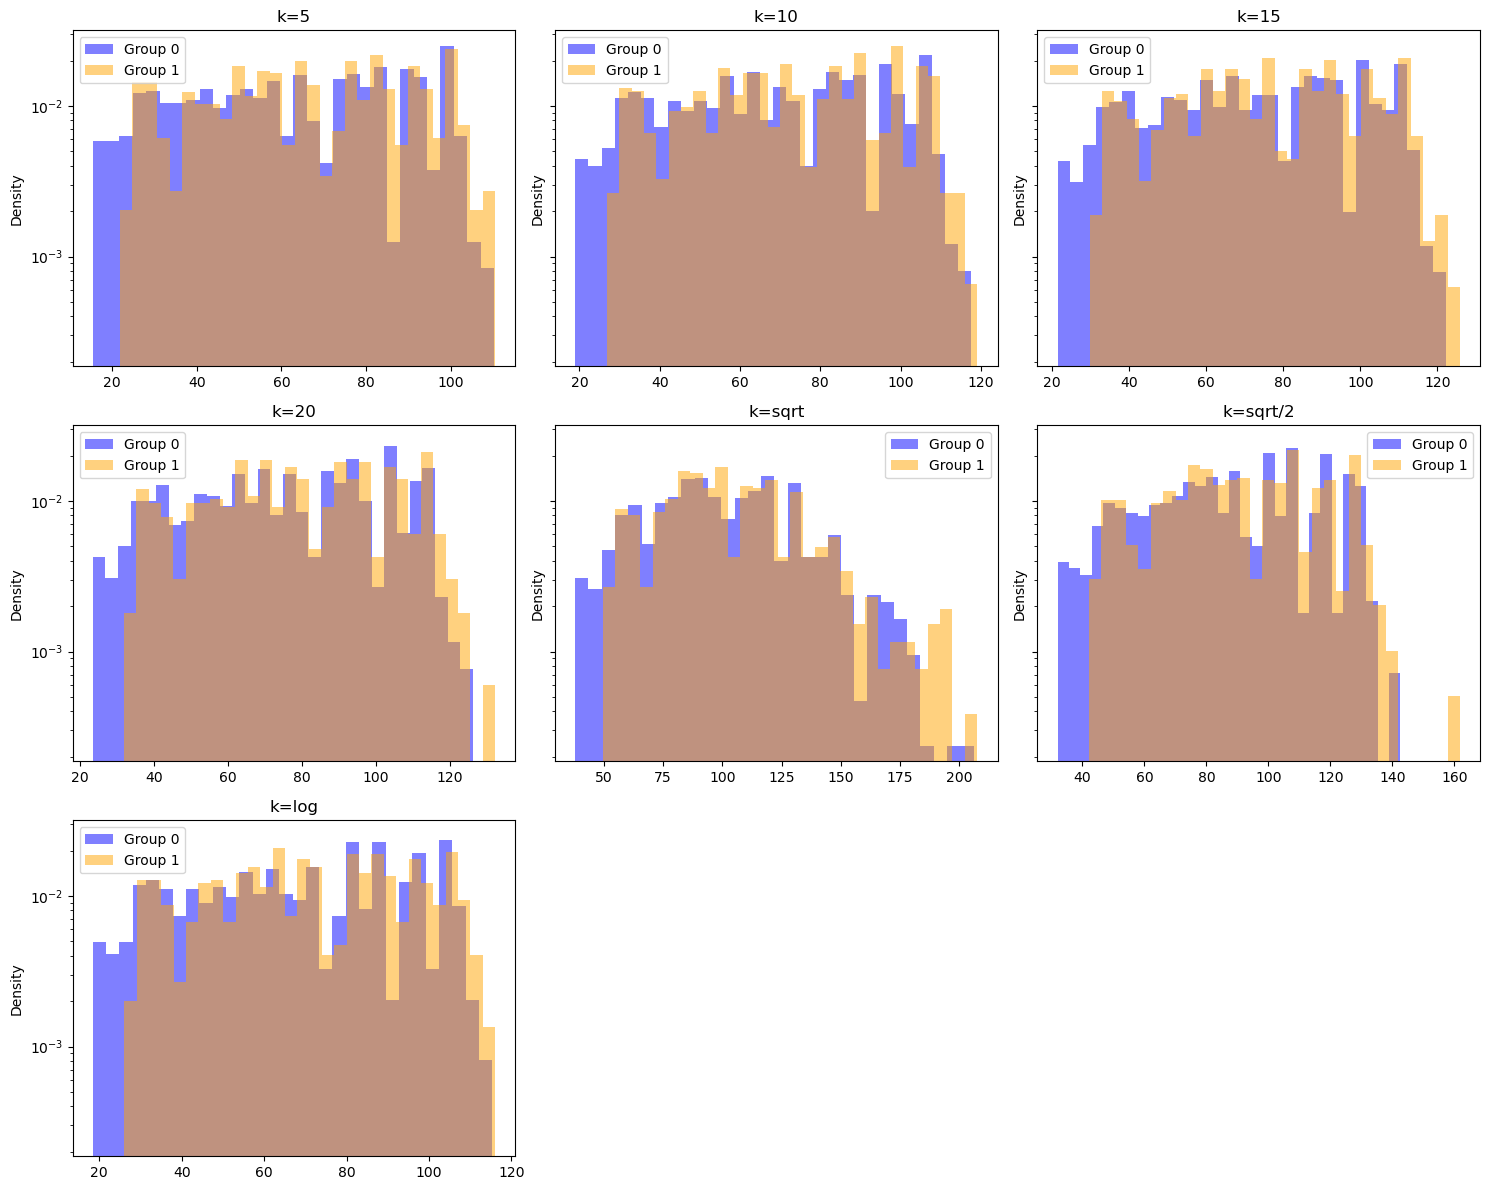

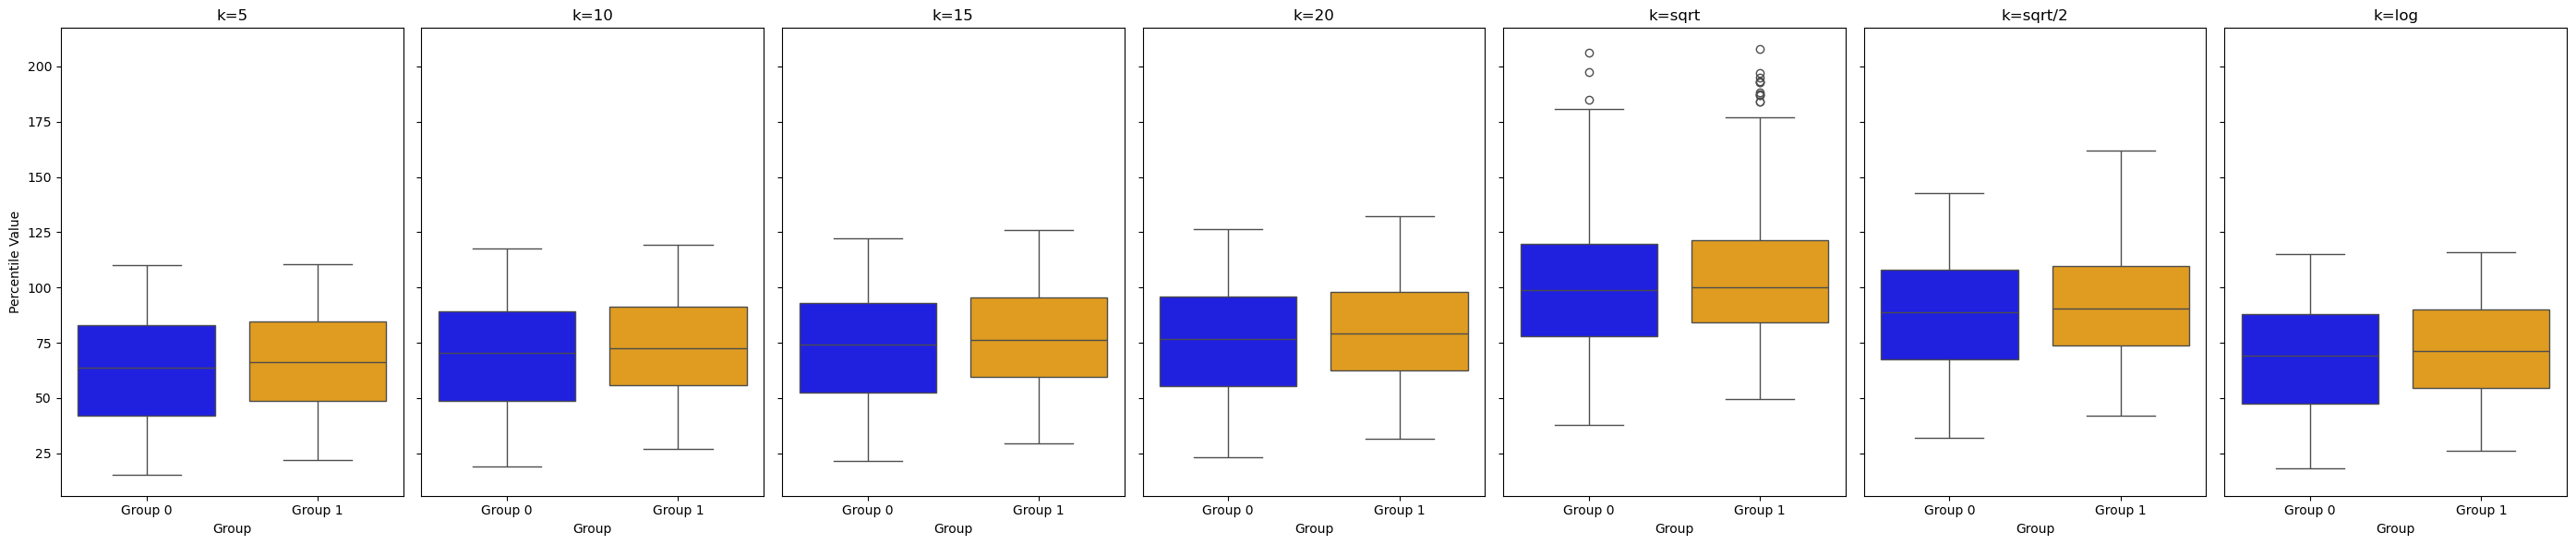

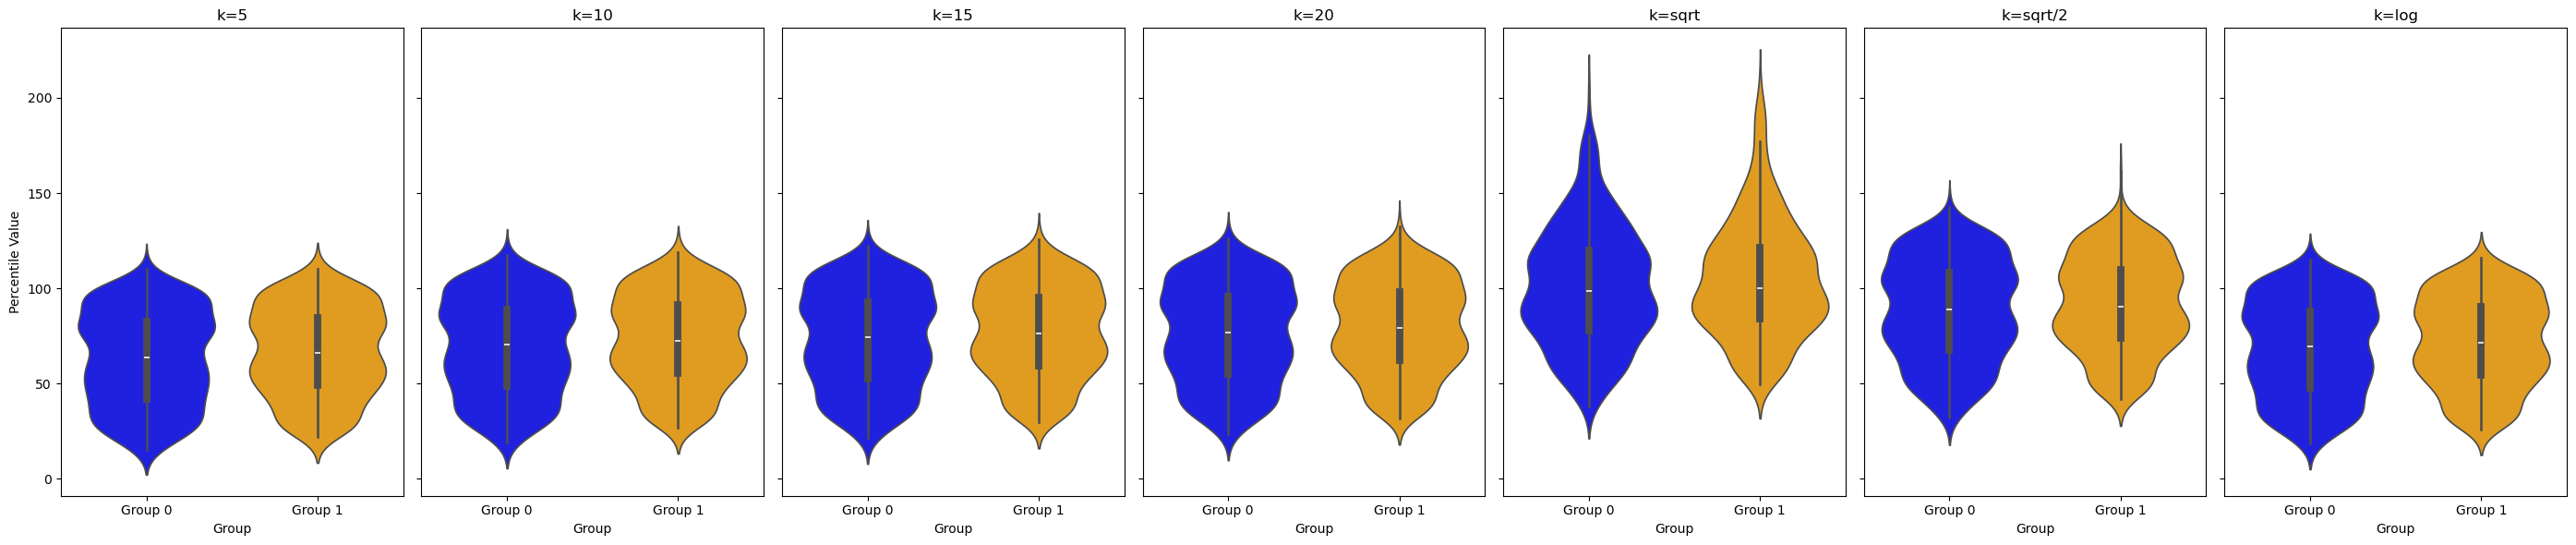

In [35]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_l2_3_all.json")
run_plots(group0, group1, k_values)

IndexError: list index out of range

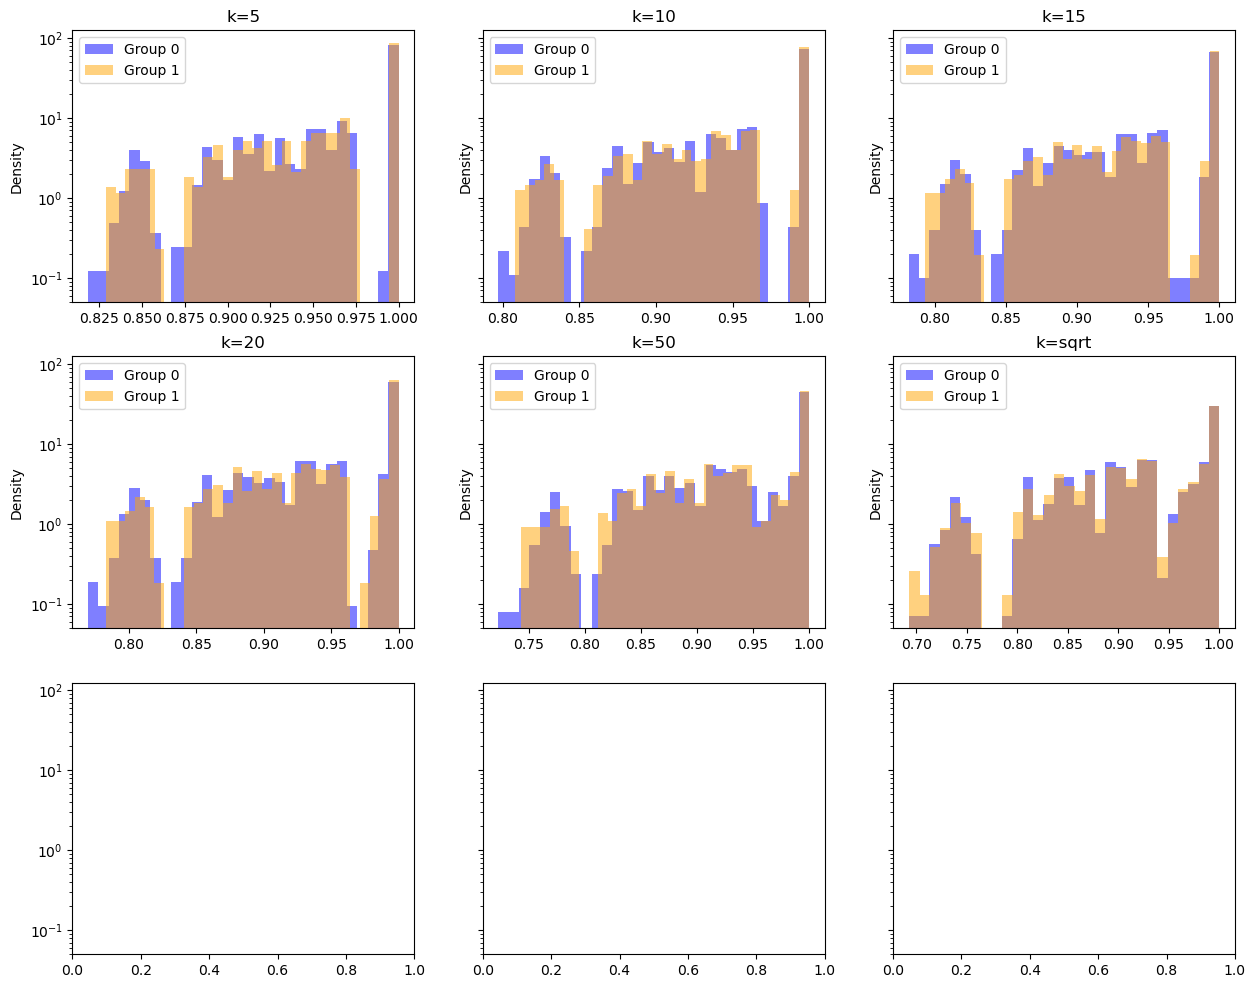

In [ ]:
group0,group1 = load_json_groups(colon_path)
run_plots(group0, group1, k_values)

## Analyzing Outlines

In [32]:
def load_json_and_extract_features_as_lists(json_path, stack=False):
    """Load JSON file, extract statistical features, and return structured lists of lists for each group."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    
    for sample_name, percentiles_dict in data.items():
        # Convert the JSON data structure to a list of lists for each sample
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]  # Convert each k-value dictionary entry to a list

        # Extract statistical features for this sample
        features_df = extract_statistical_features_from_percentiles([sample_data], list(percentiles_dict.keys()), stack)

        # Initialize lists for each feature across all k values
        iqr_values = ['iqr']
        lower_tail_range_values = ['lower_tail_range']
        upper_tail_range_values = ['upper_tail_range']
        lower_tail_ratio_values = ['lower_tail_ratio']
        upper_tail_ratio_values = ['upper_tail_ratio']
        percentile_90_10_diff_values = ['percentile_90_10_diff']
        percentile_95_5_diff_values = ['percentile_95_5_diff']
        
        # Populate each feature list with values from all k's in the original JSON order
        for col in features_df.columns[1:]:  # Skip 'Sample' column
            if 'iqr' in col:
                iqr_values.append(features_df[col].iloc[0])
            elif 'lower_tail_range' in col:
                lower_tail_range_values.append(features_df[col].iloc[0])
            elif 'upper_tail_range' in col:
                upper_tail_range_values.append(features_df[col].iloc[0])
            elif 'lower_tail_ratio' in col:
                lower_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'upper_tail_ratio' in col:
                upper_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'percentile_90_10_diff' in col:
                percentile_90_10_diff_values.append(features_df[col].iloc[0])
            elif 'percentile_95_5_diff' in col:
                percentile_95_5_diff_values.append(features_df[col].iloc[0])

        # Combine all feature lists for this sample
        sample_features = [
            iqr_values,
            lower_tail_range_values,
            upper_tail_range_values,
            lower_tail_ratio_values,
            upper_tail_ratio_values,
            percentile_90_10_diff_values,
            percentile_95_5_diff_values,
        ]
        
        # Append to the appropriate group based on sample_name
        if 'H' in sample_name or 'low' in sample_name:
            group_0.append(sample_features)
        elif 'OC' in sample_name or 'high' in sample_name:
            group_1.append(sample_features)
    
    return group_0, group_1

    
def extract_statistical_features_from_percentiles(samples, k_labels, stack=False):
    """Extract statistical metrics from specified percentiles for each k value in each sample.
    
    Parameters:
    - samples: List of samples, where each sample is a list of lists.
               Each inner list has the format [k_value, p5, p15, p25, p35, p50, p70, p80, p90, p95].
    - k_labels: List of labels for each k value (e.g., [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']).
    - stack: if another percentile vector for the same k value was concatanated(for example: PCA values)
    Returns:
    - DataFrame of statistical features for each sample and k value.
    """
    feature_list = []

    for sample_idx, sample in enumerate(samples):
        sample_features = {}
        sample_features['Sample'] = sample_idx
        
        for k_index, k_label in enumerate(k_labels):
            # Extract the provided percentiles for this k value
            percentiles = sample[k_index][1:]  # Exclude the k_value itself, just get percentiles
            
            if stack:
                perc = []
                half_size = len(percentiles) // 2
                for i in range (half_size):
                    value = 0.7 * percentiles[i] + 0.3 * percentiles[half_size + i]
                    perc.append(value)
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = perc
            else:
                # Map the percentiles to variables for clarity
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = percentiles

            # Calculate key features
            iqr = p70 - p25  # Interquartile Range (estimated as 75-25 range)
            lower_tail_range = p25 - p5  # Approximate lower tail range as 25-5
            upper_tail_range = p95 - p70  # Approximate upper tail range as 95-75
            
            # Calculate ratios
            lower_tail_ratio = lower_tail_range / iqr if iqr != 0 else 0
            upper_tail_ratio = upper_tail_range / iqr if iqr != 0 else 0
            
            # Additional quantile differences
            percentile_90_10_diff = p90 - p15  # 90th - 10th percentile difference
            percentile_95_5_diff = p95 - p5    # 95th - 5th percentile difference

            # Store features in the dictionary with keys indicating k value and metric
            sample_features[f'k={k_label}_iqr'] = iqr
            sample_features[f'k={k_label}_lower_tail_range'] = lower_tail_range
            sample_features[f'k={k_label}_upper_tail_range'] = upper_tail_range
            sample_features[f'k={k_label}_lower_tail_ratio'] = lower_tail_ratio
            sample_features[f'k={k_label}_upper_tail_ratio'] = upper_tail_ratio
            sample_features[f'k={k_label}_percentile_90_10_diff'] = percentile_90_10_diff
            sample_features[f'k={k_label}_percentile_95_5_diff'] = percentile_95_5_diff
        
        # Add this sample's features to the list
        feature_list.append(sample_features)
    
    # Convert the list of feature dictionaries to a DataFrame
    feature_df = pd.DataFrame(feature_list)
    return feature_df

In [33]:
feature_values = ["iqr", "lower_tail_range", "upper_tail_range", "lower_tail_ratio", "upper_tail_ratio", "percentile_90_10_diff", "percentile_95_5_diff"]


In [47]:
samples_group_0_ovarian, samples_group_1_ovarian = load_json_and_extract_features_as_lists(ovarian_path_outlines)

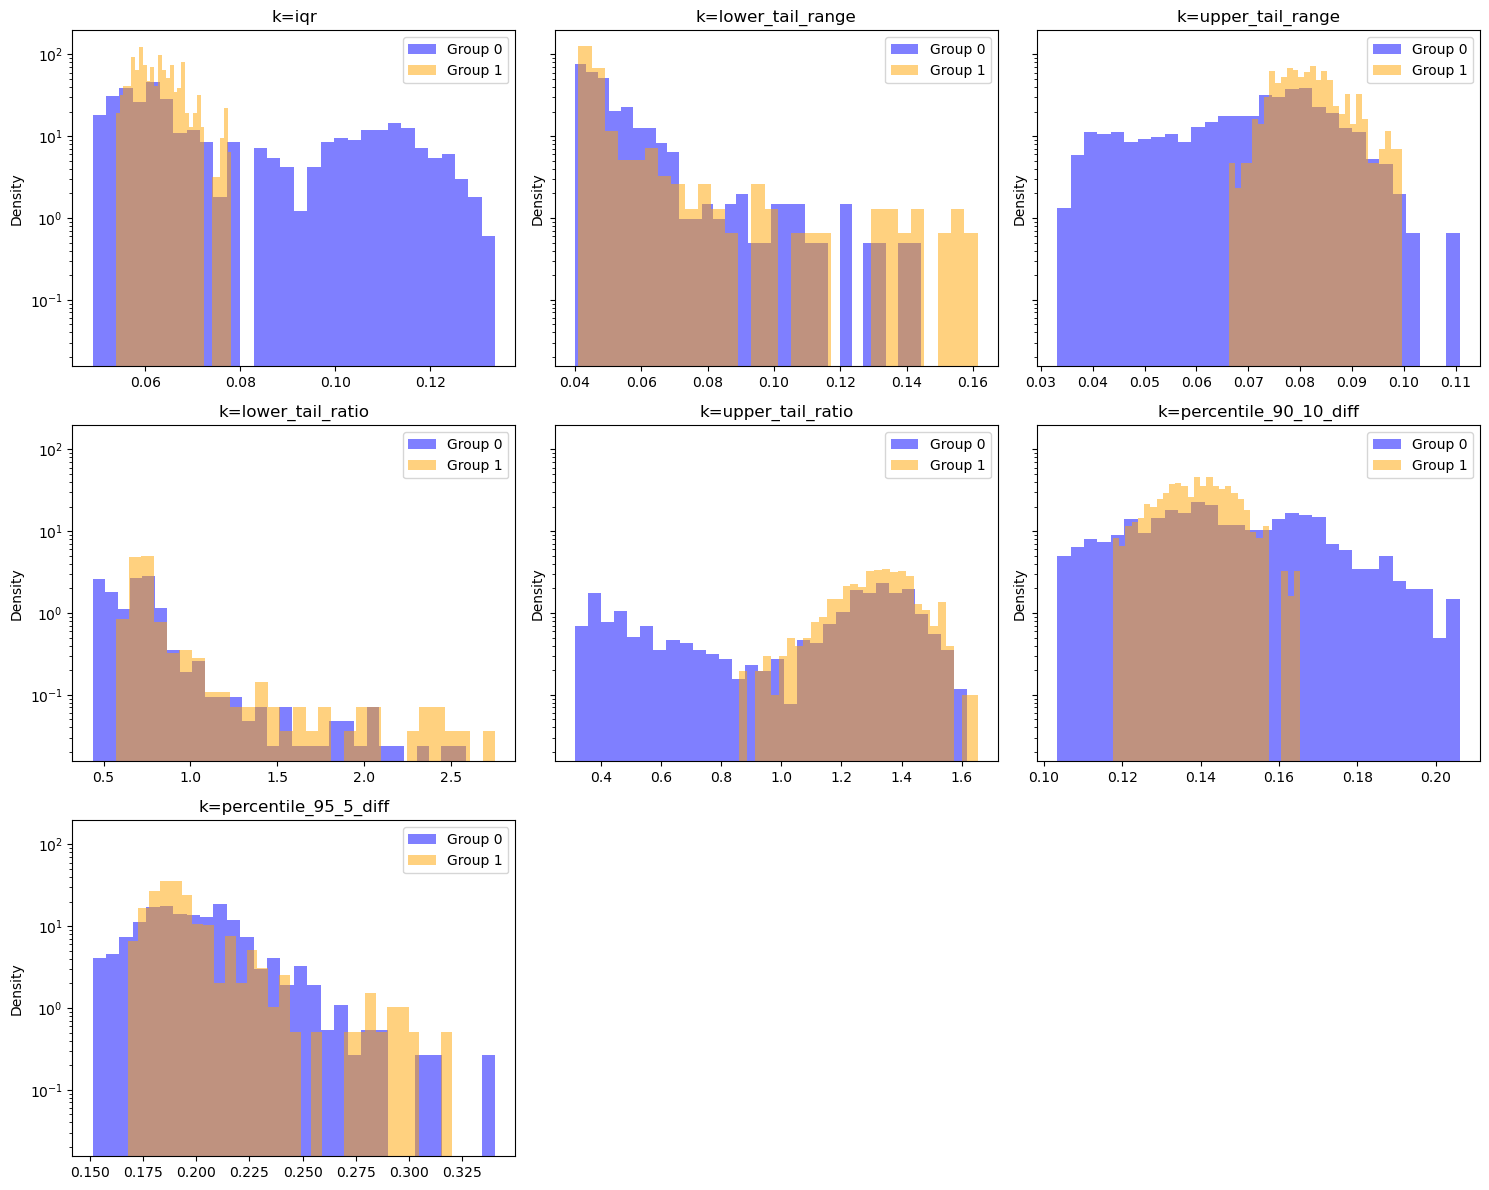

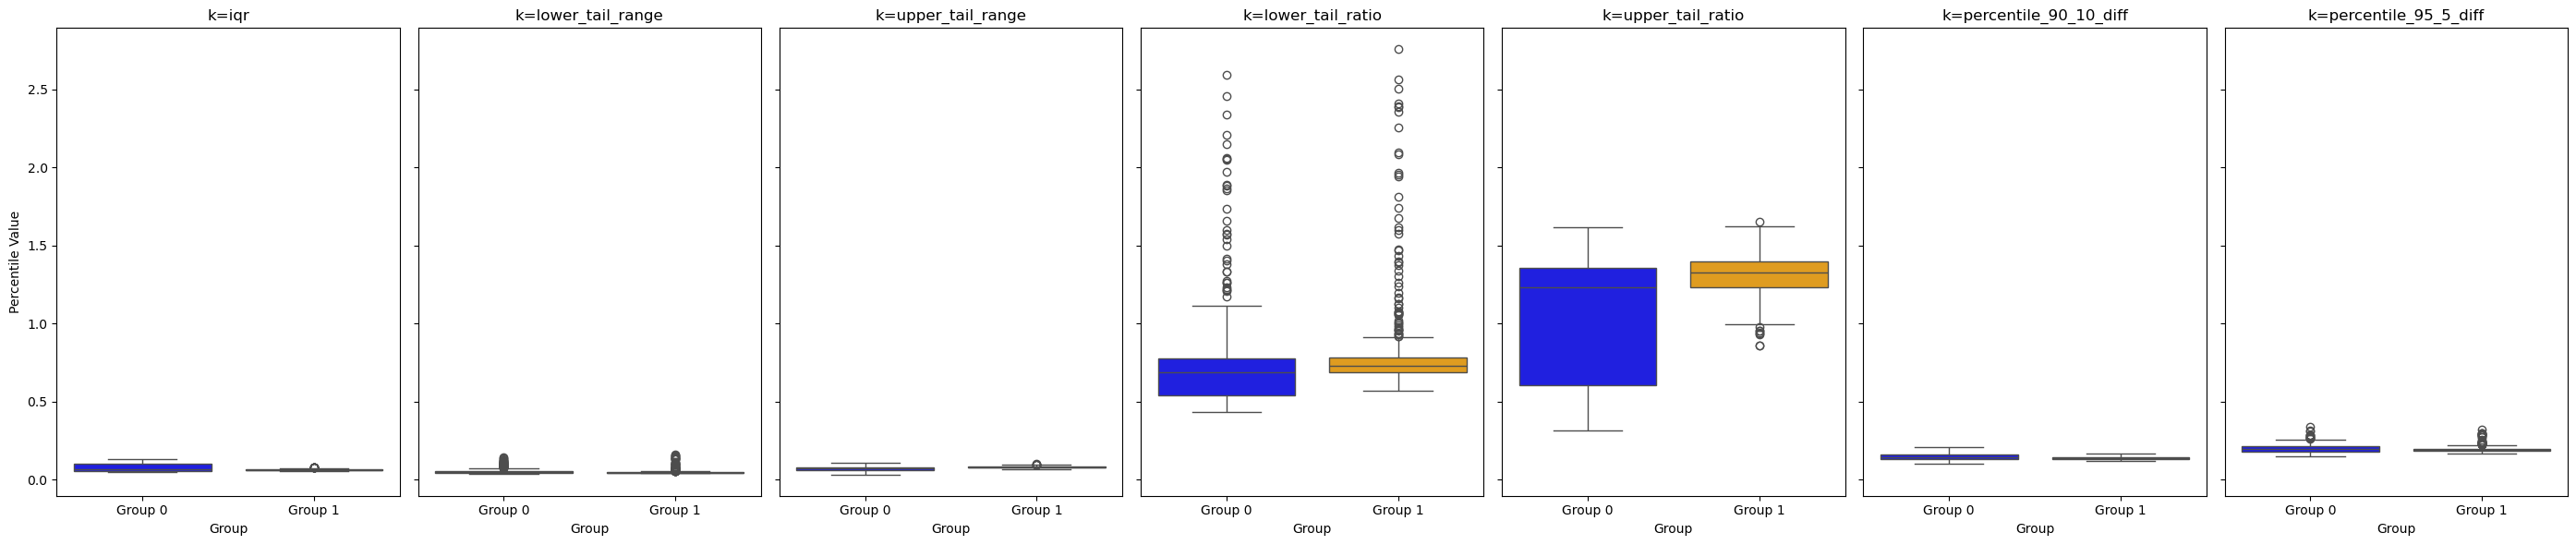

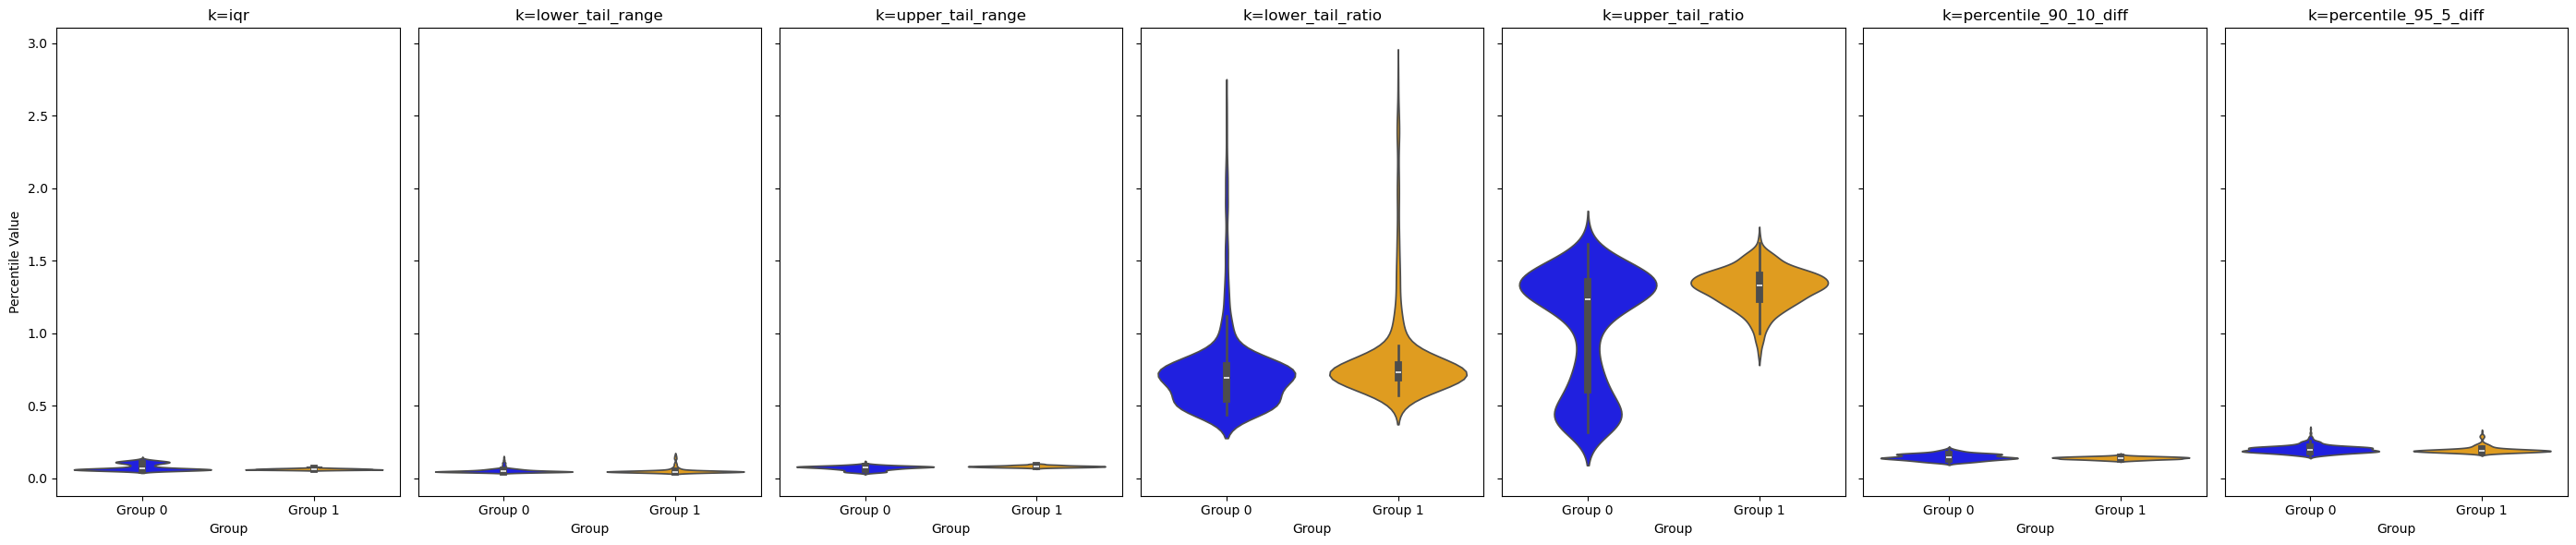

In [45]:
run_plots(samples_group_0_ovarian, samples_group_1_ovarian, feature_values)

In [71]:
samples_group_0_colon, samples_group_1_colon = load_json_and_extract_features_as_lists(colon_path_outlines, stack=True)

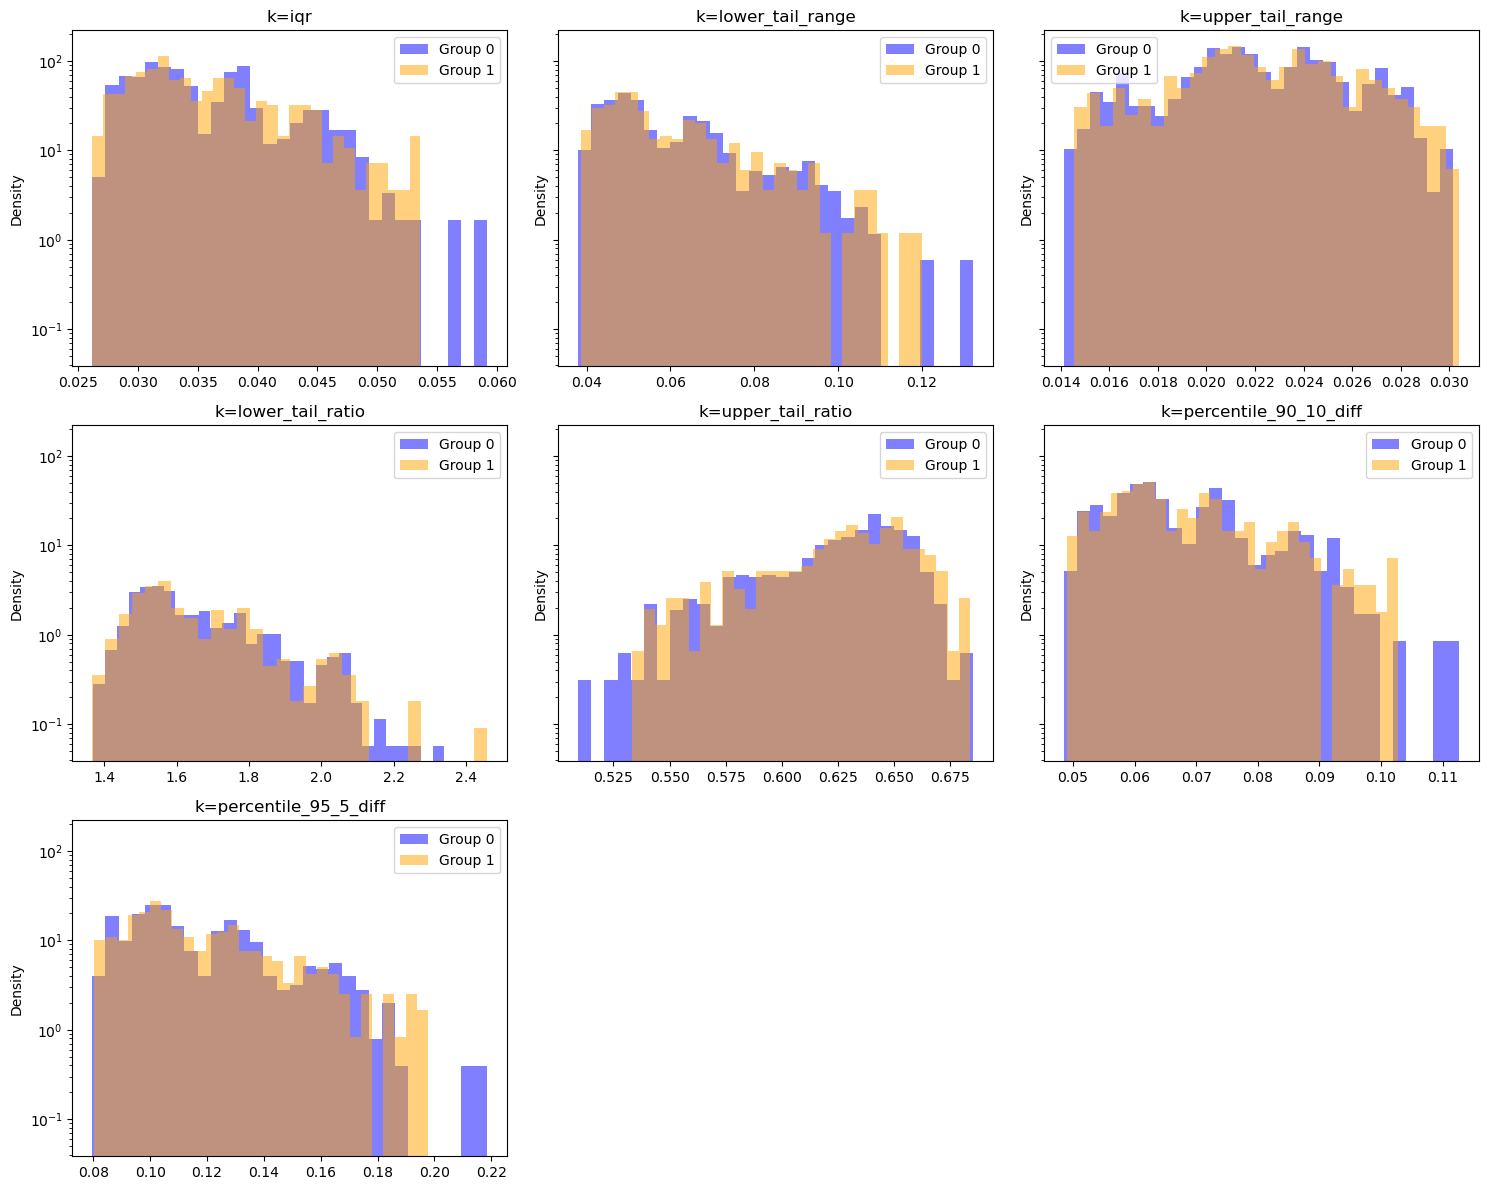

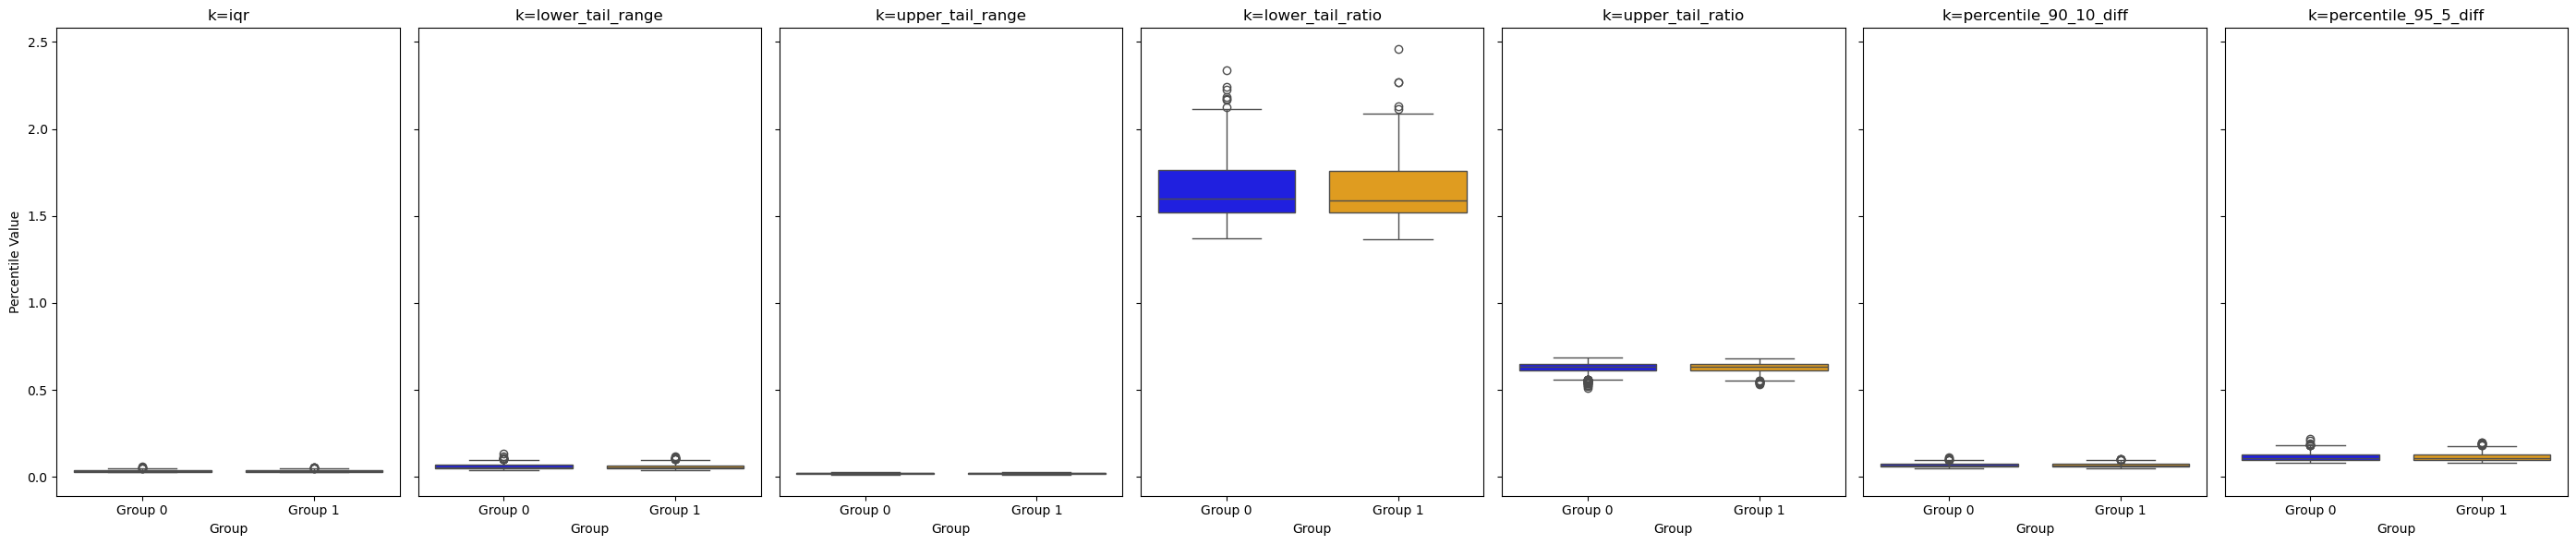

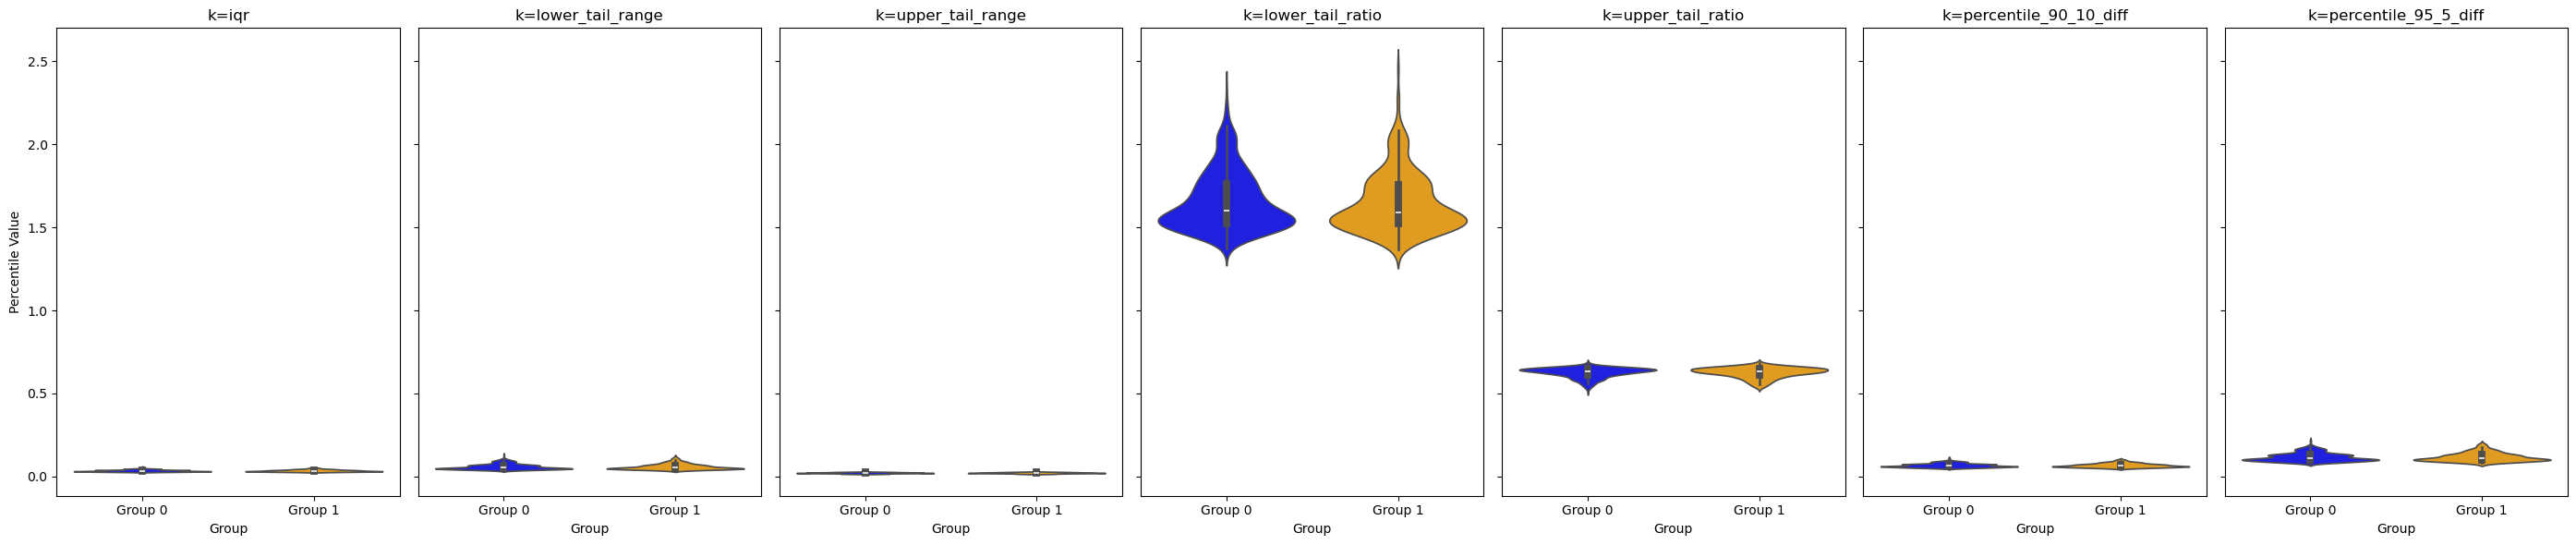

In [72]:
run_plots(samples_group_0_colon, samples_group_1_colon, feature_values)

## ML

In [34]:
def prepare_data_from_groups(group_0, group_1, average_vectors=False, vector_indices=None):
    """
    Prepare data for machine learning algorithms using extracted features from two groups.

    Parameters:
    - group_0: List of lists for Group 0, where each inner list represents a patient.
    - group_1: List of lists for Group 1, where each inner list represents a patient.
    - average_vectors: If True, averages the vectors across k values instead of concatenating.
    - vector_indices: Optional list of indices specifying which features to include.

    Returns:
    - X_train, X_test, y_train, y_test: Prepared training and testing data and labels.
    """
    data = []
    labels = []

    # Define the maximum length for padding
    max_length = 0

    # Combine groups and assign labels
    combined_data = group_0 + group_1
    combined_labels = [0] * len(group_0) + [1] * len(group_1)

    # Find the maximum length needed for padding based on selected indices
    if not average_vectors:
        if vector_indices is not None:
            # Calculate max length based only on selected features
            max_length = max(len(np.concatenate([patient_features[i][1:] for i in vector_indices if i < len(patient_features)]))
                            for patient_features in combined_data)
        else:
            # Calculate max length based on all features if no indices are specified
            max_length = max(len(np.concatenate([feature[1:] for feature in patient_features])) 
                            for patient_features in combined_data)

    for patient_features, label in zip(combined_data, combined_labels):
        # Extract values for each feature (ignore the feature names)
        vectors = [feature[1:] for feature in patient_features]
        
        if average_vectors:
            # Calculate the mean across all k values for each feature
            avg_vector = np.mean(np.array(vectors), axis=0)
            data.append(avg_vector)
        else:
            # Select specific feature indices if provided
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_features = np.concatenate(selected_vectors)
            else:
                flattened_features = np.concatenate(vectors)
            
            # Pad the concatenated features to match the max length of selected features
            padded_features = np.pad(flattened_features, (0, max_length - len(flattened_features)), 'constant')
            data.append(padded_features)

            # Append the label
            labels.append(label)

    # Convert data and labels to arrays
    data = np.array(data)
    labels = np.array(labels)

    # # Separate indices for each label
    # indices_label_0 = np.where(labels == 0)[0]
    # indices_label_1 = np.where(labels == 1)[0]

    # # Randomly select 49 samples from label 0
    # np.random.seed(42)  # Set seed for reproducibility
    # selected_indices_label_0 = np.random.choice(indices_label_0, 49, replace=False)

    # # Combine selected indices from both labels
    # balanced_indices = np.concatenate([selected_indices_label_0, indices_label_1])

    # # Create balanced data and labels based on the selected indices
    # data_balanced = data[balanced_indices]
    # labels_balanced = labels[balanced_indices]

    # # Split balanced data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(data_balanced, labels_balanced, test_size=0.2, stratify=labels_balanced, random_state=42)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    # Standardize the feature values
    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # # Verify the balance in the training set - REMOVE LATER
    # print("Training set label distribution:", np.bincount(y_train))
    # print("Test set label distribution:", np.bincount(y_test))

    return X_train, X_test, y_train, y_test

In [36]:
# Generate descriptive feature names
feature_names = [f"{feature}_{k}" for feature in feature_values for k in k_values]

In [39]:
samples_group_0_ovarian, samples_group_1_ovarian = load_json_and_extract_features_as_lists(ovarian_path_outlines)
samples_group_0_colon, samples_group_1_colon = load_json_and_extract_features_as_lists(colon_path_outlines)


In [40]:
X_train_col, X_test_col, y_train_col, y_test_col = prepare_data_from_groups(samples_group_0_colon, samples_group_1_colon)

In [41]:
print(y_train_col, len(y_train_col))
print(y_test_col, len(y_test_col))

[0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0] 111
[0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0] 28


In [42]:
results_col = []
models_col = []

In [43]:
run_evaluation(X_train_col, X_test_col, y_train_col, y_test_col, k_value="all_k", results=results_col, models=models_col)

KNN Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[15  3]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.50      0.30      0.38        10

    accuracy                           0.64        28
   macro avg       0.59      0.57      0.56        28
weighted avg       0.62      0.64      0.62        28

ROC-AUC: 0.625
Logistic Regression Results
Accuracy: 0.5
Confusion Matrix:
[[12  6]
 [ 8  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.25      0.20      0.22        10

    accuracy                           0.50        28
   macro avg       0.42      0.43      0.43        28
weighted avg       0.47      0.50      0.49        28

ROC-AUC: 0.32222222222222224
SVM Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[18  0]
 [10  0]]
Classification Report

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Random Forest Results
Accuracy: 0.75
Confusion Matrix:
[[17  1]
 [ 6  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.80      0.40      0.53        10

    accuracy                           0.75        28
   macro avg       0.77      0.67      0.68        28
weighted avg       0.76      0.75      0.72        28

ROC-AUC: 0.5333333333333333
MLP Results
Accuracy: 0.5357142857142857
Confusion Matrix:
[[12  6]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.33      0.30      0.32        10

    accuracy                           0.54        28
   macro avg       0.48      0.48      0.48        28
weighted avg       0.53      0.54      0.53        28

ROC-AUC: 0.4833333333333334
XGBoost Results:
Accuracy: 0.6071428571428571
Confusion Matrix:
[[12  6]
 [ 5  5]]
Classific

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-17 13:04:09.720002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-12-17 13:04:09.722201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


I0000 00:00:1734433453.272207  871815 service.cc:146] XLA service 0x7f727c0047f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734433453.272328  871815 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1734433453.272339  871815 service.cc:154]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-12-17 13:04:13.300582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-17 13:04:13.423589: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
I0000 00:00:1734433454.469970  871815 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Neural Network Results:
Accuracy: 0.5714285714285714
Confusion Matrix:
[[16  2]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        18
           1       0.00      0.00      0.00        10

    accuracy                           0.57        28
   macro avg       0.31      0.44      0.36        28
weighted avg       0.40      0.57      0.47        28

ROC-AUC: 0.5111111111111111


In [44]:
train_and_evaluate_nn(X_train_col, X_test_col, y_train_col, y_test_col)

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Neural Network Results:
Accuracy: 0.6071428571428571
Confusion Matrix:
[[15  3]
 [ 8  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        18
           1       0.40      0.20      0.27        10

    accuracy                           0.61        28
   macro avg       0.53      0.52      0.50        28
weighted avg       0.56      0.61      0.57        28

ROC-AUC: 0.5277777777777778


(<Sequential name=sequential_1, built=True>,
 {'model': 'Neural Network',
  'accuracy': 0.6071428571428571,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.65      0.83      0.73        18\n           1       0.40      0.20      0.27        10\n\n    accuracy                           0.61        28\n   macro avg       0.53      0.52      0.50        28\nweighted avg       0.56      0.61      0.57        28\n'})

### Specific algorithms

In [75]:
train_grid_mlp(X_train_col, X_test_col, y_train_col, y_test_col)

9167.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9167.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9168.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9168.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9168.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9168.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9168.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9169.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9169.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9169.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
9169.66s - pydevd: Sending message related to proc

Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}
Best Score: 0.6952569169960474
Test Accuracy: 0.4642857142857143
[[11  7]
 [ 8  2]]


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test_random_forest(X_train, X_test, y_train, y_test):
    random_forest = RandomForestClassifier(class_weight='balanced')
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Random Forest Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print("ROC-AUC:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

test_random_forest(X_train_col, X_test_col, y_train_col, y_test_col)

Random Forest Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[15  3]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.50      0.30      0.38        10

    accuracy                           0.64        28
   macro avg       0.59      0.57      0.56        28
weighted avg       0.62      0.64      0.62        28

Balanced Accuracy: 0.5667
ROC-AUC: 0.5472222222222223


In [71]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test_xgboost(X_train, X_test, y_train, y_test):
    # model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(90 / 49))
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)

    # accuracy = accuracy_score(y_test, y_pred)
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # class_report = classification_report(y_test, y_pred)

    # print("XGBoost Results:")
    # print(f"Accuracy: {accuracy}")
    # print("Confusion Matrix:")
    # print(conf_matrix)
    # print("Classification Report:")
    # print(class_report)
    # print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    # Train the XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(90 / 49))
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class (1)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Set a custom threshold
    threshold = 0.5 # Example: lower the threshold to 0.4
    y_pred_adjusted = (y_probs >= threshold).astype(int)

    # Evaluate the adjusted predictions
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    class_report = classification_report(y_test, y_pred_adjusted)

    # Print evaluation results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

test_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

Accuracy: 0.6428571428571429
Confusion Matrix:
[[12  6]
 [ 4  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.50      0.60      0.55        10

    accuracy                           0.64        28
   macro avg       0.62      0.63      0.63        28
weighted avg       0.66      0.64      0.65        28



In [70]:
train_grid_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

4714.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4714.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4715.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4715.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4715.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4715.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4715.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4716.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4716.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4716.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4716.68s - pydevd: Sending message related to proc

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1.5, 'subsample': 0.7}
Best Recall Score from Grid Search: 0.6947619047619048

XGBoost Results with Best Parameters for Label 1 Recall:
Accuracy: 0.6071428571428571
Confusion Matrix:
[[14  4]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        18
           1       0.43      0.30      0.35        10

    accuracy                           0.61        28
   macro avg       0.55      0.54      0.54        28
weighted avg       0.58      0.61      0.59        28

Balanced Accuracy: 0.5389
ROC-AUC: 0.6111111111111112


In [73]:
train_grid_rf(X_train_col, X_test_col, y_train_col, y_test_col)


7801.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7801.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7802.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7802.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7802.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7802.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7802.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7803.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7803.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7803.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7803.63s - pydevd: Sending message related to proc

Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best ROC-AUC Score from Grid Search: 0.6319444444444444

Random Forest Results with Best Parameters:
Accuracy: 0.6428571428571429
Confusion Matrix:
[[15  3]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.50      0.30      0.38        10

    accuracy                           0.64        28
   macro avg       0.59      0.57      0.56        28
weighted avg       0.62      0.64      0.62        28

Balanced Accuracy: 0.5667
ROC-AUC: 0.5888888888888889


In [47]:
train_grid_svm(X_train_col, X_test_col, y_train_col, y_test_col)
train_grid_mlp(X_train_col, X_test_col, y_train_col, y_test_col)

Best Parameters: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Best Score: 0.6940711462450593
Test Accuracy: 0.5357142857142857
[[14  4]
 [ 9  1]]


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converge

Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}
Best Score: 0.7126482213438736
Test Accuracy: 0.4642857142857143
[[12  6]
 [ 9  1]]


### Feature selection

In [48]:
# Map each feature name to its full feature type explicitly
def extract_feature_type(feature_name):
    for feature_type in ['iqr', 'lower_tail_range', 'upper_tail_range', 'lower_tail_ratio', 
                 'upper_tail_ratio', 'percentile_90_10_diff', 'percentile_95_5_diff']:
        if feature_name.startswith(feature_type):
            return feature_type
    return "Unknown"  # In case a feature doesn't match (for debugging)

def test_rf(X_train, X_test, y_train, y_test, feature_names):
    random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print("Random Forest Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Feature importance
    feature_importances = random_forest.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df)

    # Use the full feature type for aggregation
    importance_df['Feature_Type'] = importance_df['Feature'].apply(extract_feature_type)
    aggregated_importance = importance_df.groupby('Feature_Type')['Importance'].sum().sort_values(ascending=False)
    
    print("\nAggregated Feature Importances by Feature Type:")
    print(aggregated_importance)

    # return top N features
    N = 5
    top_features = aggregated_importance.head(N).index.tolist()
    return top_features


top_featurs_colon = test_rf(X_train_col, X_test_col, y_train_col, y_test_col, feature_names)

Random Forest Results:
Accuracy: 0.6071428571428571
Confusion Matrix:
[[13  5]
 [ 6  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.44      0.40      0.42        10

    accuracy                           0.61        28
   macro avg       0.56      0.56      0.56        28
weighted avg       0.60      0.61      0.60        28


Feature Importances:
                         Feature  Importance
19       upper_tail_range_sqrt/2    0.044227
12       lower_tail_range_sqrt/2    0.043352
17           upper_tail_range_20    0.039280
18         upper_tail_range_sqrt    0.035832
21            lower_tail_ratio_5    0.034161
11         lower_tail_range_sqrt    0.031618
25         lower_tail_ratio_sqrt    0.030757
14            upper_tail_range_5    0.029960
9            lower_tail_range_15    0.029924
27          lower_tail_ratio_log    0.027477
16           upper_tail_range_15    0.025382

In [49]:
top_feat_col_indices = [feature_values.index(feature) for feature in top_featurs_colon]


In [50]:
X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3 = prepare_data_from_groups(samples_group_0_colon, samples_group_1_colon, vector_indices=top_feat_col_indices)

In [51]:
print(y_train_col_3, len(y_train_col_3))
print(y_test_col_3, len(y_test_col_3))

[1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0] 111
[0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0] 28


In [52]:
run_evaluation(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3, k_value="all_k", results=[], models=[])

KNN Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[15  3]
 [ 7  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.50      0.30      0.38        10

    accuracy                           0.64        28
   macro avg       0.59      0.57      0.56        28
weighted avg       0.62      0.64      0.62        28

ROC-AUC: 0.6722222222222223
Logistic Regression Results
Accuracy: 0.5714285714285714
Confusion Matrix:
[[16  2]
 [10  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        18
           1       0.00      0.00      0.00        10

    accuracy                           0.57        28
   macro avg       0.31      0.44      0.36        28
weighted avg       0.40      0.57      0.47        28

ROC-AUC: 0.3166666666666667
SVM Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[17  1]
 [ 9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Neural Network Results:
Accuracy: 0.5357142857142857
Confusion Matrix:
[[13  5]
 [ 8  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        18
           1       0.29      0.20      0.24        10

    accuracy                           0.54        28
   macro avg       0.45      0.46      0.45        28
weighted avg       0.50      0.54      0.51        28

ROC-AUC: 0.48888888888888893


In [74]:
train_grid_xgboost(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

8178.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8178.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8178.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8178.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8178.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8179.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8179.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8179.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8179.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8179.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8180.03s - pydevd: Sending message related to proc

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.5, 'subsample': 0.7}
Best Recall Score from Grid Search: 0.6496428571428572

XGBoost Results with Best Parameters for Label 1 Recall:
Accuracy: 0.5714285714285714
Confusion Matrix:
[[12  6]
 [ 6  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        18
           1       0.40      0.40      0.40        10

    accuracy                           0.57        28
   macro avg       0.53      0.53      0.53        28
weighted avg       0.57      0.57      0.57        28

Balanced Accuracy: 0.5333
ROC-AUC: 0.5666666666666667


### GO

In [ ]:
train_grid_rf(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 20, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 15, 'rf__n_estimators': 100}
Best ROC-AUC Score from Grid Search: 0.5321739130434783

Random Forest Results with Best Parameters:
Accuracy: 0.5416666666666666
Confusion Matrix:
[[9 6]
 [5 4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.40      0.44      0.42         9

    accuracy                           0.54        24
   macro avg       0.52      0.52      0.52        24
weighted avg       0.55      0.54      0.55        24

ROC-AUC: 0.5259259259259259


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test(X_train, X_test, y_train, y_test):
    # Define the Random Forest model with the specified parameters
    rf_model = RandomForestClassifier(
        bootstrap=False,
        max_depth=15,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=200,
        class_weight='balanced'  # Optional: Add class weighting if you have class imbalance
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print evaluation metrics
    print("Random Forest Results with Specified Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}")

test(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

Random Forest Results with Specified Parameters:
Accuracy: 0.5833333333333334
Confusion Matrix:
[[11  4]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.43      0.33      0.38         9

    accuracy                           0.58        24
   macro avg       0.54      0.53      0.53        24
weighted avg       0.57      0.58      0.57        24

ROC-AUC: 0.5037037037037038


OVARIAN

In [ ]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = prepare_data_from_groups(samples_group_0_ovarian, samples_group_1_ovarian)

In [ ]:
results_ov = []
models_ov = []

In [ ]:
run_evaluation(X_train_ov, X_test_ov, y_train_ov, y_test_ov, k_value="all_k", results=results_ov, models=models_ov)

KNN Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[12  5]
 [ 5  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.55      0.55      0.55        11

    accuracy                           0.64        28
   macro avg       0.63      0.63      0.63        28
weighted avg       0.64      0.64      0.64        28

ROC-AUC: 0.7085561497326203
Logistic Regression Results
Accuracy: 0.5357142857142857
Confusion Matrix:
[[12  5]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        17
           1       0.38      0.27      0.32        11

    accuracy                           0.54        28
   macro avg       0.49      0.49      0.48        28
weighted avg       0.51      0.54      0.52        28

ROC-AUC: 0.6844919786096257
SVM Results
Accuracy: 0.5357142857142857
Confusion Matrix:
[[10  7]
 [ 6

## Printing Samples

In [28]:
def prepare_data_with_samples(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []
    sample_names = []  # To store sample names

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name

    data = np.array(data)
    labels = np.array(labels)
    sample_names = np.array(sample_names)

    # Include sample_names in the train-test split
    X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(data, labels, sample_names, test_size=0.2, stratify=labels)

    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Return train-test data, labels, and sample names
    return X_train, X_test, y_train, y_test, train_names, test_names

In [29]:
all_results_samples, labels_dict_samples = load_results(colon_path, data_type=data_type)

X_train_samples, X_test_samples, y_train_samples, y_test_samples, train_names, test_names = prepare_data_with_samples(all_results_samples, labels_dict_samples)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score


def train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names):
    # Create a pipeline with scaling and Random Forest
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
    ])

    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [20, 50, 100, 200, 500],
        'rf__max_depth': [5, 10, 15, 20],
        'rf__min_samples_split': [2, 5, 10, 15],
        'rf__min_samples_leaf': [1, 2, 4, 8],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy method Score from Grid Search:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Identify false negatives (True label = 1, Predicted label = 0)
    false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
    false_negative_names = [test_names[i] for i in false_negative_indices]

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    # Print false negative names
    print("\nFalse Negative Samples:")
    for name in false_negative_names:
        print(name)

In [67]:
train_grid_rf_samples(X_train_samples, X_test_samples, y_train_samples, y_test_samples, test_names)

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
7342.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7343.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
7344.13s - pydevd: Sending message related to process being r

Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best Accuracy method Score from Grid Search: 0.5165476190476191

Random Forest Results with Best Parameters:
Accuracy: 0.4642857142857143
Confusion Matrix:
[[12  6]
 [ 9  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        18
           1       0.14      0.10      0.12        10

    accuracy                           0.46        28
   macro avg       0.36      0.38      0.37        28
weighted avg       0.42      0.46      0.44        28

Balanced Accuracy: 0.3833
ROC-AUC: 0.4222222222222222

False Negative Samples:
pool5_S11_high
pool5_S15_high
pool4_S6_high
pool6_S14_high
pool2_S15_high
pool9_S10_high
pool1_S2_high
pool5_S18_high
pool7_S11_high


In [70]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

def train_grid_xgboost_samples(X_train, X_test, y_train, y_test, test_names):
    # Define the parameter grid, including scale_pos_weight
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1.5, 1.7, 1.8, 2.0]  # Adjusted based on class imbalance for colon (90/49)
    }

    # Initialize the XGBClassifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize GridSearchCV, focusing on recall for label 1
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=0)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Recall Score from Grid Search:", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Identify false negatives (True label = 1, Predicted label = 0)
    false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
    false_negative_names = [test_names[i] for i in false_negative_indices]

    print("\nXGBoost Results with Best Parameters for Label 1 Recall:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    # Print false negative names
    print("\nFalse Negative Samples:")
    for name in false_negative_names:
        print(name)

In [ ]:
train_grid_xgboost_samples(X_train_samples, X_test_samples, y_train_samples, y_test_samples, test_names)

In [ ]:
def test_2(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []
    sample_names = []  # To store sample names

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])
            sample_names.append(sample_name)  # Keep track of sample name

    data = np.array(data)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    
    # Initialize a DataFrame to store stats
    stats_df = pd.DataFrame(columns=["sample_name", "false_negative_appearances", "total_test_appearances", "average_balanced_accuracy"])

    # Create dictionaries to track counts and scores
    false_negative_counts = {}
    test_group_counts = {}
    balanced_accuracy_scores = {}

    # Initialize a list to store stats
    stats_list = []

    for i in range(15):
        print(f"\n####### round {i + 1} #######")
        
        # Include sample_names in the train-test split
        X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(
            data, labels, sample_names, test_size=0.2, stratify=labels
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train and evaluate the model
        def train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names):
            # Create a pipeline with scaling and Random Forest
            pipe = Pipeline([
                ('scaler', StandardScaler()),  # Feature scaling
                ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
            ])

            # Define the parameter grid
            param_grid = {
                'rf__n_estimators': [20, 50, 100, 200, 500],
                'rf__max_depth': [5, 10, 15, 20],
                'rf__min_samples_split': [2, 5, 10, 15],
                'rf__min_samples_leaf': [1, 2, 4, 8],
                'rf__max_features': ['sqrt', 'log2'],
                'rf__bootstrap': [True, False]
            }

            # Initialize GridSearchCV with the pipeline and parameter grid
            cv = StratifiedKFold(n_splits=5, shuffle=True)
            grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=0)

            # Fit the model
            grid_search.fit(X_train, y_train)

            # Get the best parameters and best score
            print("Best Parameters:", grid_search.best_params_)
            print("Best Accuracy method Score from Grid Search:", grid_search.best_score_)

            # Predict using the best model
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            # Evaluate the balanced accuracy
            balanced_acc = balanced_accuracy_score(y_test, y_pred)

            # Identify false negatives (True label = 1, Predicted label = 0)
            false_negative_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == 1 and pred == 0]
            false_negative_names = [test_names[i] for i in false_negative_indices]

            # Update the false negative counts
            for name in false_negative_names:
                false_negative_counts[name] = false_negative_counts.get(name, 0) + 1

            # Update the total test group counts
            for name in test_names:
                if "high" in name:
                    test_group_counts[name] = test_group_counts.get(name, 0) + 1
                    # Track the balanced accuracy for each sample
                    if name not in balanced_accuracy_scores:
                        balanced_accuracy_scores[name] = []
                    balanced_accuracy_scores[name].append(balanced_acc)

        train_grid_rf_samples(X_train, X_test, y_train, y_test, test_names)

    # Create a summary DataFrame
    for sample_name in test_group_counts.keys():
        stats_list.append({
            "sample_name": sample_name,
            "false_negative_appearances": false_negative_counts.get(sample_name, 0),
            "total_test_appearances": test_group_counts[sample_name],
            "average_balanced_accuracy": sum(balanced_accuracy_scores.get(sample_name, [])) / len(balanced_accuracy_scores.get(sample_name, []))
        })

    # Convert the list to a DataFrame
    stats_df = pd.DataFrame(stats_list)    
    
    return stats_df


stats_df = test_2(all_results_samples, labels_dict_samples)


####### round 1 #######
Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}
Best Accuracy method Score from Grid Search: 0.631547619047619

####### round 2 #######
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 20}
Best Accuracy method Score from Grid Search: 0.5539285714285713

####### round 3 #######
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 15, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}
Best Accuracy method Score from Grid Search: 0.5470238095238096

####### round 4 #######
Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}
Best Accuracy method Score from

# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Explained variance ratio: [0.66197355 0.13858125]
Cumulative explained variance: [0.66197355 0.80055481]


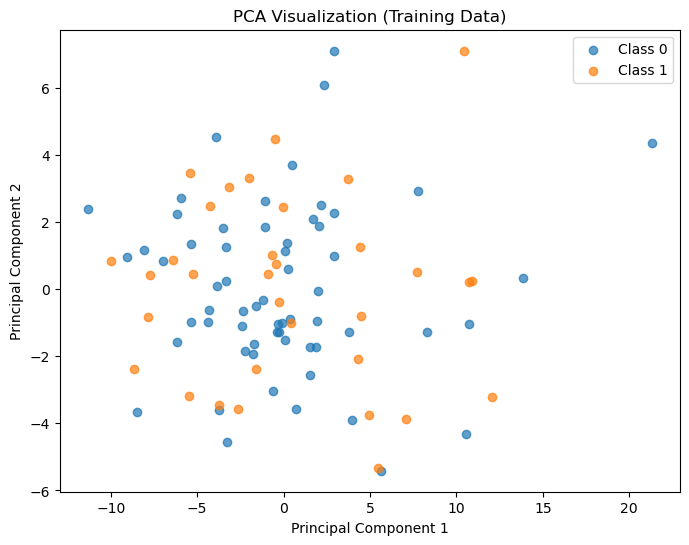

In [ ]:
# Assume X_train, X_test, y_train, y_test are provided by `prepare_data`
# X_train_col, X_test_col, y_train_col, y_test_col
# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_col)
X_test_scaled = scaler.transform(X_test_col)

# Step 2: Apply PCA to the training data
pca = PCA(n_components=2)  # Use 2 components for visualization
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Cumulative explained variance:", explained_variance.cumsum())

# Visualize PCA results (Training Data)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_col):
    plt.scatter(X_train_pca[y_train_col == label, 0], X_train_pca[y_train_col == label, 1], label=f"Class {label}", alpha=0.7)
plt.title("PCA Visualization (Training Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

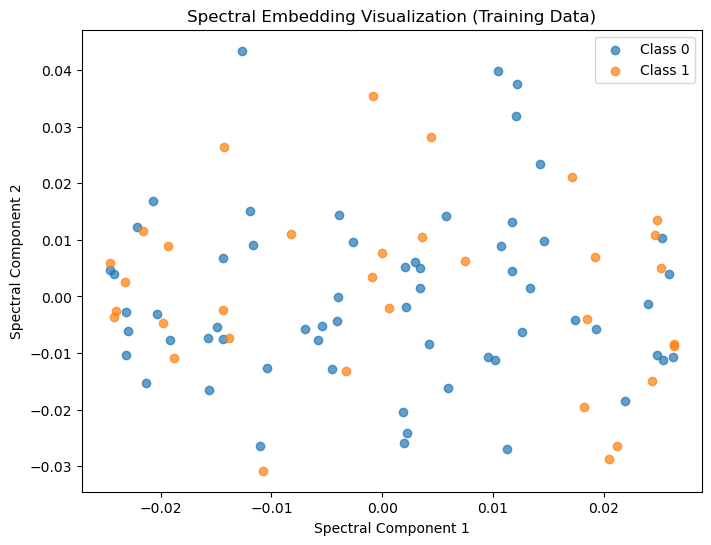

In [ ]:
# Step 3: Apply Spectral Embedding to the training data
spectral = SpectralEmbedding(n_components=3, affinity='nearest_neighbors', n_neighbors=50)
X_train_spectral = spectral.fit_transform(X_train_scaled)

# Visualize Spectral Embedding results (Training Data)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train_col):
    plt.scatter(X_train_spectral[y_train_col == label, 0], X_train_spectral[y_train_col == label, 1], label=f"Class {label}", alpha=0.7)
plt.title("Spectral Embedding Visualization (Training Data)")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.legend()
plt.show()